# Project - Deploying a Machine Learning Model on Heroku with FastAPI

## Data Description

### Source

This data was extracted from the census bureau database found at http://www.census.gov/ftp/pub/DES/www/welcome.html
```
Donor: Ronny Kohavi and Barry Becker,
       Data Mining and Visualization
       Silicon Graphics.
       e-mail: ronnyk@sgi.com for questions.
```
* Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).
* 48842 instances, mix of continuous and discrete    (train=32561, test=16281)
* 45222 if instances with unknown values are removed (train=30162, test=15060)
* Duplicate or conflicting instances : 6
* Class probabilities for adult.all file
  * Probability for the label '>50K'  : 23.93% / 24.78% (without unknowns)
  * Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)

For this project, only __train set__ of __unfiltered instanes__ is used - __32561 instances__.

### Objective
Prediction task is to determine whether a person makes over 50K a year.


### Transformations
Conversion of original data as follows:
1. Discretized gross income into two ranges with threshold 50,000.
2. Convert U.S. to US to avoid periods.
3. Convert Unknown to "?"
4. Run MLC++ GenCVFiles to generate data,test.


### Description of fnlwgt (final weight)
The weights on the CPS files are controlled to independent estimates of the
civilian noninstitutional population of the US.  These are prepared monthly
for us by Population Division here at the Census Bureau.  We use 3 sets of
controls.
These are:
1. A single cell estimate of the population 16+ for each state.
2. Controls for Hispanic Origin by age and sex.
3. Controls by Race, age and sex.
We use all three sets of controls in our weighting program and "rake" through
them 6 times so that by the end we come back to all the controls we used.
The term estimate refers to population totals derived from CPS by creating
"weighted tallies" of any specified socio-economic characteristics of the
population.

People with similar demographic characteristics should have
similar weights.  There is one important caveat to remember
about this statement.  That is that since the CPS sample is
actually a collection of 51 state samples, each with its own
probability of selection, the statement only applies within
state.

### Data values
| name | values |
|------|--------|
| __salary__ | >50K, <=50K.|
| age | continuous |
| workclass | Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked |
| fnlwgt | continuous |
| education | Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool |
| education-num | continuous |
| marital-status | Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse |
| occupation | Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces |
| relationship | Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried |
| race | White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black |
| sex | Female, Male |
| capital-gain | continuous |
| capital-loss | continuous |
| hours-per-week | continuous |
| native-country | United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands |

## Getting raw data

In [1]:
import pandas as pd

In [2]:
DATA_PATH = '../data/census.csv'
df = pd.read_csv(DATA_PATH)
df.head()

age          workclass   fnlgt   education   education-num  \
0   39          State-gov   77516   Bachelors              13   
1   50   Self-emp-not-inc   83311   Bachelors              13   
2   38            Private  215646     HS-grad               9   
3   53            Private  234721        11th               7   
4   28            Private  338409   Bachelors              13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

    capital-gain   capital-loss   hours-per-week  native-country  salary  
0           2174              0               40   United-States   <=50K  
1              0              0               13   United-States   <=50K  
2              0              0               40   United-States   <=50K  
3              0              0               40   United-States   <=50K  
4              0              0               40            Cuba   <=50K

## Initial ETL

### Remove trailing spaces

In [3]:
print(f'Trailing spaces: \n{df.columns.tolist()[:5]} ...')
def trim(dataset: pd.DataFrame, asdf: float = 0.0):
    dataset.columns = [col.strip() for col in dataset.columns]
    dataset.columns = [col.replace('-', '_') for col in dataset.columns]

    return dataset.applymap(
        lambda value: value.strip() if isinstance(value, str) else value)

df = trim(df)
print(f'Removing spaces: \n{df.columns.tolist()[:5]} ...')

Trailing spaces: 
['age', ' workclass', ' fnlgt', ' education', ' education-num'] ...
Removing spaces: 
['age', 'workclass', 'fnlgt', 'education', 'education_num'] ...


### Replace `?` with `Unknown` for readability

In [4]:
def mark_question_row(row):
    return row.astype(str).str.contains('?', regex=False).any()

df.loc[df.apply(mark_question_row, axis=1)].head()

age workclass   fnlgt     education  education_num         marital_status  \
14   40   Private  121772     Assoc-voc             11     Married-civ-spouse   
27   54         ?  180211  Some-college             10     Married-civ-spouse   
38   31   Private   84154  Some-college             10     Married-civ-spouse   
51   18   Private  226956       HS-grad              9          Never-married   
61   32         ?  293936       7th-8th              4  Married-spouse-absent   

       occupation   relationship                race     sex  capital_gain  \
14   Craft-repair        Husband  Asian-Pac-Islander    Male             0   
27              ?        Husband  Asian-Pac-Islander    Male             0   
38          Sales        Husband               White    Male             0   
51  Other-service      Own-child               White  Female             0   
61              ?  Not-in-family               White    Male             0   

    capital_loss  hours_per_week native_country salary  
14             0              40              ?   >50K  
27             0              60          South   >50K  
38             0              38              ?   >50K  
51             0              30              ?  <=50K  
61             0              40              ?  <=50K

In [5]:
print(f'Number of rows containing `?`: {df.apply(mark_question_row, axis=1).sum()}')
df.replace({'?': 'Unknown'}, inplace = True)
print(f'Number of rows containing `?` after replacement: {df.apply(mark_question_row, axis=1).sum()}')


Number of rows containing `?`: 2399
Number of rows containing `?` after replacement: 0


### Remove duplicate rows

In [6]:
df[df.duplicated(keep = False)].sort_values('fnlgt').head()

age         workclass  fnlgt     education  education_num  \
28846   39           Private  30916       HS-grad              9   
25624   39           Private  30916       HS-grad              9   
21875   49           Private  31267       7th-8th              4   
7920    49           Private  31267       7th-8th              4   
22494   49  Self-emp-not-inc  43479  Some-college             10   

           marital_status    occupation relationship   race   sex  \
28846  Married-civ-spouse  Craft-repair      Husband  White  Male   
25624  Married-civ-spouse  Craft-repair      Husband  White  Male   
21875  Married-civ-spouse  Craft-repair      Husband  White  Male   
7920   Married-civ-spouse  Craft-repair      Husband  White  Male   
22494  Married-civ-spouse  Craft-repair      Husband  White  Male   

       capital_gain  capital_loss  hours_per_week native_country salary  
28846             0             0              40  United-States  <=50K  
25624             0             0              40  United-States  <=50K  
21875             0             0              40  United-States  <=50K  
7920              0             0              40  United-States  <=50K  
22494             0             0              40  United-States  <=50K

In [7]:
print(f'Number of rows: {df.shape[0]}')
df.drop_duplicates(inplace = True)
print(f'Number of rows after duplicates drop: {df.shape[0]}')

Number of rows: 32561
Number of rows after duplicates drop: 32537


## `pandas_profiling` for initial EDA

In [8]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## ETL (for baseline)

In [9]:
DATA_PATH = '../data/train.csv'
df = pd.read_csv(DATA_PATH)
df.head()

age         workclass   fnlgt     education  education_num  \
0   50           Private   20795       HS-grad              9   
1   24  Self-emp-not-inc   34918     Assoc-voc             11   
2   32           Private  210562       HS-grad              9   
3   38         Local-gov  223004  Some-college             10   
4   46      Self-emp-inc  284799  Some-college             10   

       marital_status         occupation   relationship   race     sex  \
0  Married-civ-spouse    Farming-fishing        Husband  White    Male   
1       Never-married      Other-service      Unmarried  White  Female   
2  Married-civ-spouse  Machine-op-inspct        Husband  White    Male   
3            Divorced    Protective-serv  Not-in-family  White    Male   
4  Married-civ-spouse              Sales        Husband  White    Male   

   capital_gain  capital_loss  hours_per_week native_country salary  
0             0             0              60  United-States   >50K  
1             0             0              38  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              75  United-States  <=50K  
4             0             0              60  United-States  <=50K

In [10]:
RANDOM_STATE = 48
TEST_SIZE = 0.2

### Columns' types

`education` and `education-num` have Pearson's correlation of 1.0, but `education_num` has ordinal information.

In [11]:
cat_features = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
num_features = ['age', 'fnlgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
target = 'salary'

df = df[cat_features + num_features + [target]]

### Ordinal columns' order

In [12]:
workclass_order = ['Private', 'Self-emp-inc', 'Self-emp-not-inc', 'Local-gov', 'State-gov', 'Federal-gov', 'Without-pay', 'Never-worked', 'Unknown', 'Other']
education_order = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate', 'Other']
marital_status_order = ['Married-civ-spouse', 'Married-AF-spouse', 'Married-spouse-absent', 'Separated', 'Divorced', 'Widowed', 'Never-married', 'Other']
relationship_order = ['Husband', 'Wife', 'Own-child', 'Unmarried', 'Not-in-family', 'Other-relative', 'Other']

cat_order = {
    'workclass': workclass_order,
    'education': education_order,
    'marital_status': marital_status_order,
    'occupation': None,
    'relationship': relationship_order,
    'race': None,
    'sex': None,
    'native_country': None
}

## Train and test data

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

y = df[target]
X = df.loc[:, df.columns != target]

target_encoder = LabelBinarizer()
y = target_encoder.fit_transform(y.values).ravel()
for i, c in enumerate(target_encoder.classes_):
    print(f'Label `{c}` encoded into: `{i}`')
print(f'Transformed target shape: {y.shape}')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, stratify = y, random_state = RANDOM_STATE)

Label `<=50K` encoded into: `0`
Label `>50K` encoded into: `1`
Transformed target shape: (26029,)


### Transforming independent variables

In [14]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


### mandatotry fields - age, sex
### custom logic field - education_num
categorical = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
categorical_preproc = OneHotEncoder(sparse=False, handle_unknown='ignore')

zero_imputed = ['fnlgt', 'capital_gain', 'capital_loss']
zero_imputer = SimpleImputer(strategy='constant', fill_value=0)

median_imputed = ['hours_per_week']
median_imputer = SimpleImputer(strategy='median')

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_preproc, categorical),
        ('zero_imputed', zero_imputer, zero_imputed),
        ('median_imputed', median_imputer, median_imputed)
    ],
    remainder='passthrough',
)

X_train = preprocessor.fit_transform(X_train[num_features + cat_features])
print(f'Transformed train data shape: {X_train.shape}')

X_test = preprocessor.transform(X_test[num_features + cat_features])
print(f'Transformed test data shape: {X_test.shape}')

Transformed train data shape: (20823, 108)
Transformed test data shape: (5206, 108)


## Baseline model(s)

### Gradient Boosting classifier (sklearn)

F1 beta score        : 0.685
Precision (PPV) score: 0.783
Recal (TPR) score    : 0.608


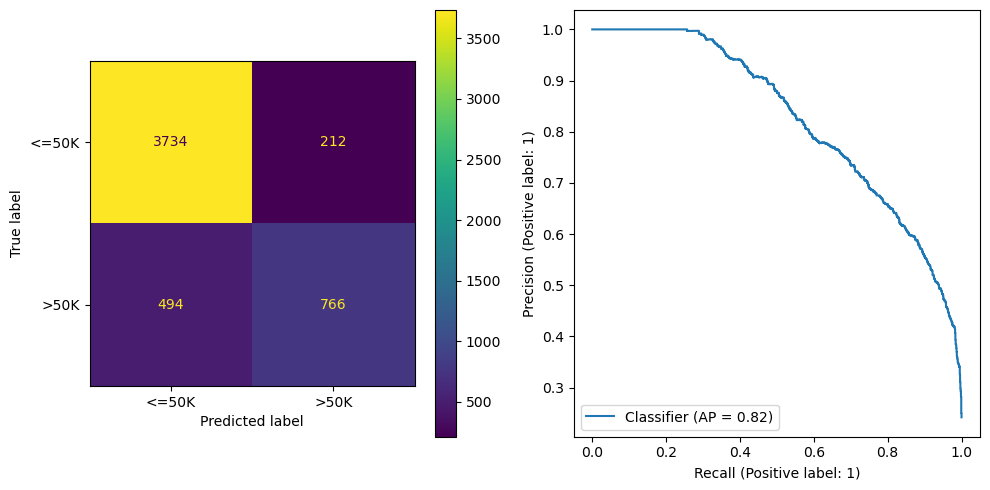

In [15]:
from sklearn.metrics import fbeta_score, precision_score, recall_score, ConfusionMatrixDisplay, PrecisionRecallDisplay

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state = RANDOM_STATE)
gbc.fit(X_train, y_train)
# make the prediction using the resulting model
y_pred = gbc.predict(X_test)
y_pred_proba = gbc.predict_proba(X_test)

fbeta = fbeta_score(y_test, y_pred, beta=1, zero_division=1)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)

print(f'F1 beta score        : {fbeta:.3f}')
print(f'Precision (PPV) score: {precision:.3f}')
print(f'Recal (TPR) score    : {recall:.3f}')

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels = target_encoder.classes_,
    ax = axes[0]
)

PrecisionRecallDisplay.from_predictions(
    y_test,
    y_pred_proba[:, 1],
    ax = axes[1]
)

plt.tight_layout()
plt.show()

#### Testing exporting and loading model and running inference

In [16]:
from joblib import dump, load
MODEL_PATH = 'model_pipeline.joblib'

model_pipeline = {
    'ind_features': num_features + cat_features,
    'target': target,
    'preprocessor': preprocessor,
    'target_preprocessor': target_encoder,
    'classifier': gbc
}

dump(model_pipeline, MODEL_PATH)

['model_pipeline.joblib']

In [17]:
model = load(MODEL_PATH)

y = df[model['target']]
X = df.loc[:, df.columns != model['target']]

y = model['target_preprocessor'].transform(y).ravel()

_, X_test, _, y_test = train_test_split(X, y, test_size = TEST_SIZE, stratify = y, random_state = RANDOM_STATE)

X_test = model['preprocessor'].transform(X_test)

y_pred = model['classifier'].predict(X_test)
y_pred_proba = model['classifier'].predict_proba(X_test)

fbeta = fbeta_score(y_test, y_pred, beta=1, zero_division=1)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)

print(f'F1 beta score        : {fbeta:.3f}')
print(f'Precision (PPV) score: {precision:.3f}')
print(f'Recal (TPR) score    : {recall:.3f}')

F1 beta score        : 0.685
Precision (PPV) score: 0.783
Recal (TPR) score    : 0.608


### AdaBoost classifier (sklearn)

F1 beta score        : 0.679
Precision (PPV) score: 0.763
Recal (TPR) score    : 0.611


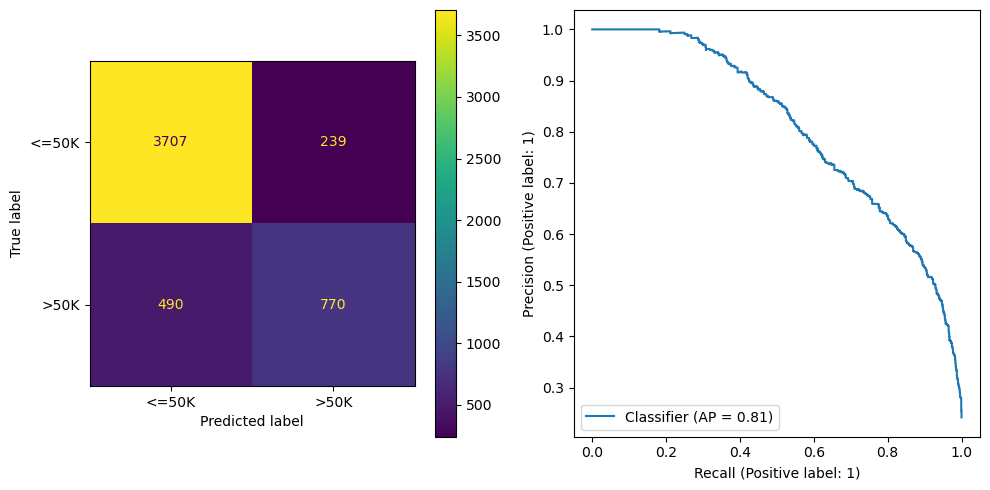

In [18]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(random_state = RANDOM_STATE)
abc.fit(X_train, y_train)

# make the prediction using the resulting model
y_pred = abc.predict(X_test)
y_pred_proba = abc.predict_proba(X_test)

fbeta = fbeta_score(y_test, y_pred, beta=1, zero_division=1)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)

print(f'F1 beta score        : {fbeta:.3f}')
print(f'Precision (PPV) score: {precision:.3f}')
print(f'Recal (TPR) score    : {recall:.3f}')

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels = target_encoder.classes_,
    ax = axes[0]
)

PrecisionRecallDisplay.from_predictions(
    y_test,
    y_pred_proba[:, 1],
    ax = axes[1]
)

plt.tight_layout()
plt.show()

### Random forest classifier

F1 beta score        : 0.670
Precision (PPV) score: 0.732
Recal (TPR) score    : 0.618


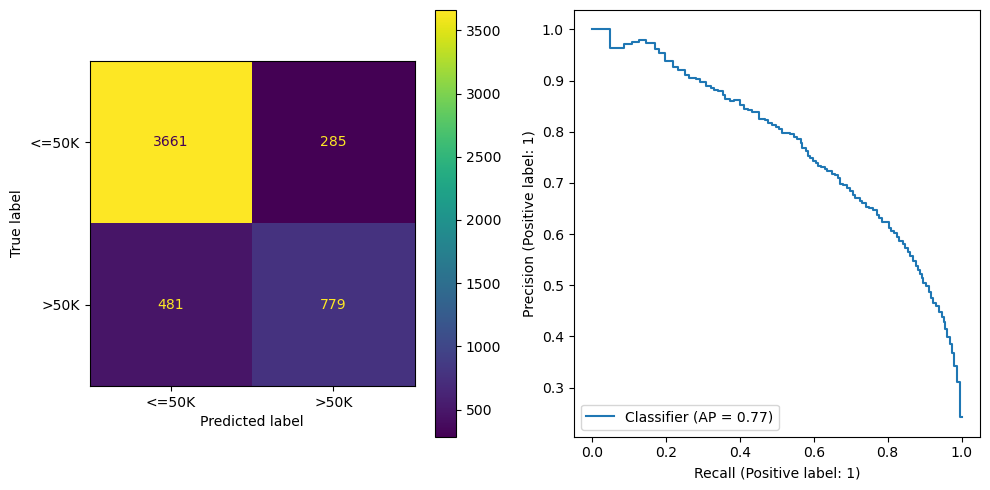

In [19]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state = RANDOM_STATE)
rfc.fit(X_train, y_train)

# make the prediction using the resulting model
y_pred = rfc.predict(X_test)
y_pred_proba = rfc.predict_proba(X_test)

fbeta = fbeta_score(y_test, y_pred, beta=1, zero_division=1)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)

print(f'F1 beta score        : {fbeta:.3f}')
print(f'Precision (PPV) score: {precision:.3f}')
print(f'Recal (TPR) score    : {recall:.3f}')

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels = target_encoder.classes_,
    ax = axes[0]
)

PrecisionRecallDisplay.from_predictions(
    y_test,
    y_pred_proba[:, 1],
    ax = axes[1]
)

plt.tight_layout()
plt.show()

### Logistic regression classifier

F1 beta score        : 0.402
Precision (PPV) score: 0.747
Recal (TPR) score    : 0.275


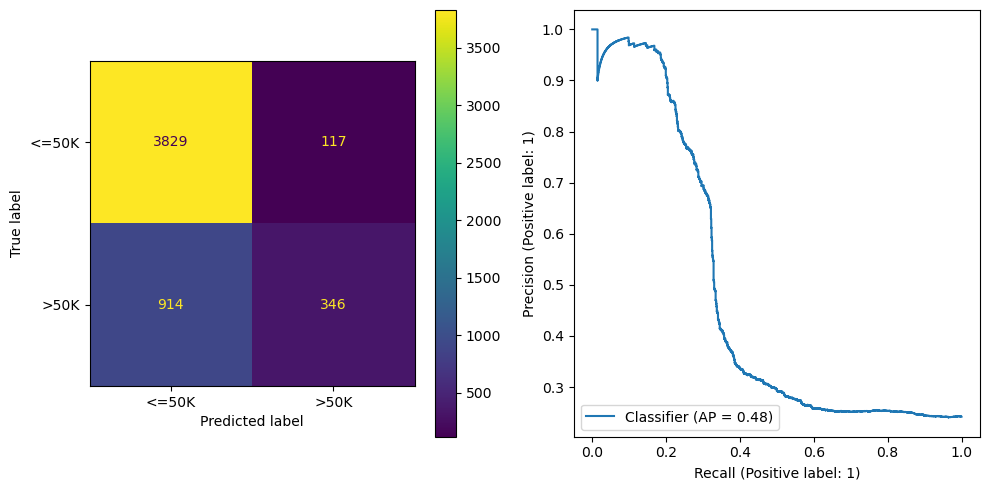

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state = RANDOM_STATE)
lr.fit(X_train, y_train)

# make the prediction using the resulting model
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)

fbeta = fbeta_score(y_test, y_pred, beta=1, zero_division=1)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)

print(f'F1 beta score        : {fbeta:.3f}')
print(f'Precision (PPV) score: {precision:.3f}')
print(f'Recal (TPR) score    : {recall:.3f}')

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels = target_encoder.classes_,
    ax = axes[0]
)

PrecisionRecallDisplay.from_predictions(
    y_test,
    y_pred_proba[:, 1],
    ax = axes[1]
)

plt.tight_layout()
plt.show()

### Catboost - does not require preprocessing of categorical variables

#### ETL for catboost

In [21]:
y = df[target]
X = df.loc[:, df.columns != target]

y = target_encoder.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, stratify = y, random_state = RANDOM_STATE)

#### Model training

F1 beta score        : 0.720
Precision (PPV) score: 0.777
Recal (TPR) score    : 0.671


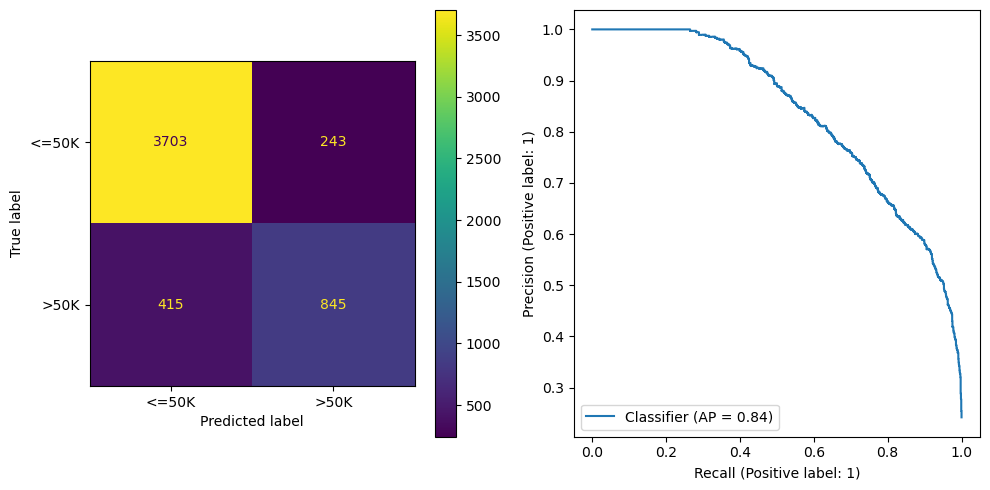

In [22]:
from catboost import CatBoostClassifier


cbc = CatBoostClassifier(
    cat_features = cat_features,
    random_seed = RANDOM_STATE,
    verbose = False)

# train the model
cbc.fit(X_train, y_train)

# make the prediction using the resulting model
y_pred = cbc.predict(X_test)
y_pred_proba = cbc.predict_proba(X_test)

fbeta = fbeta_score(y_test, y_pred, beta=1, zero_division=1)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)

print(f'F1 beta score        : {fbeta:.3f}')
print(f'Precision (PPV) score: {precision:.3f}')
print(f'Recal (TPR) score    : {recall:.3f}')

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels = target_encoder.classes_,
    ax = axes[0]
)

PrecisionRecallDisplay.from_predictions(
    y_test,
    y_pred_proba[:, 1],
    ax = axes[1]
)

plt.tight_layout()
plt.show()

## EDA

### Target feature plots

In [23]:
import seaborn as sns
sns.set_theme(style="darkgrid")

#### Categorical variables - Plots without percentile filtration

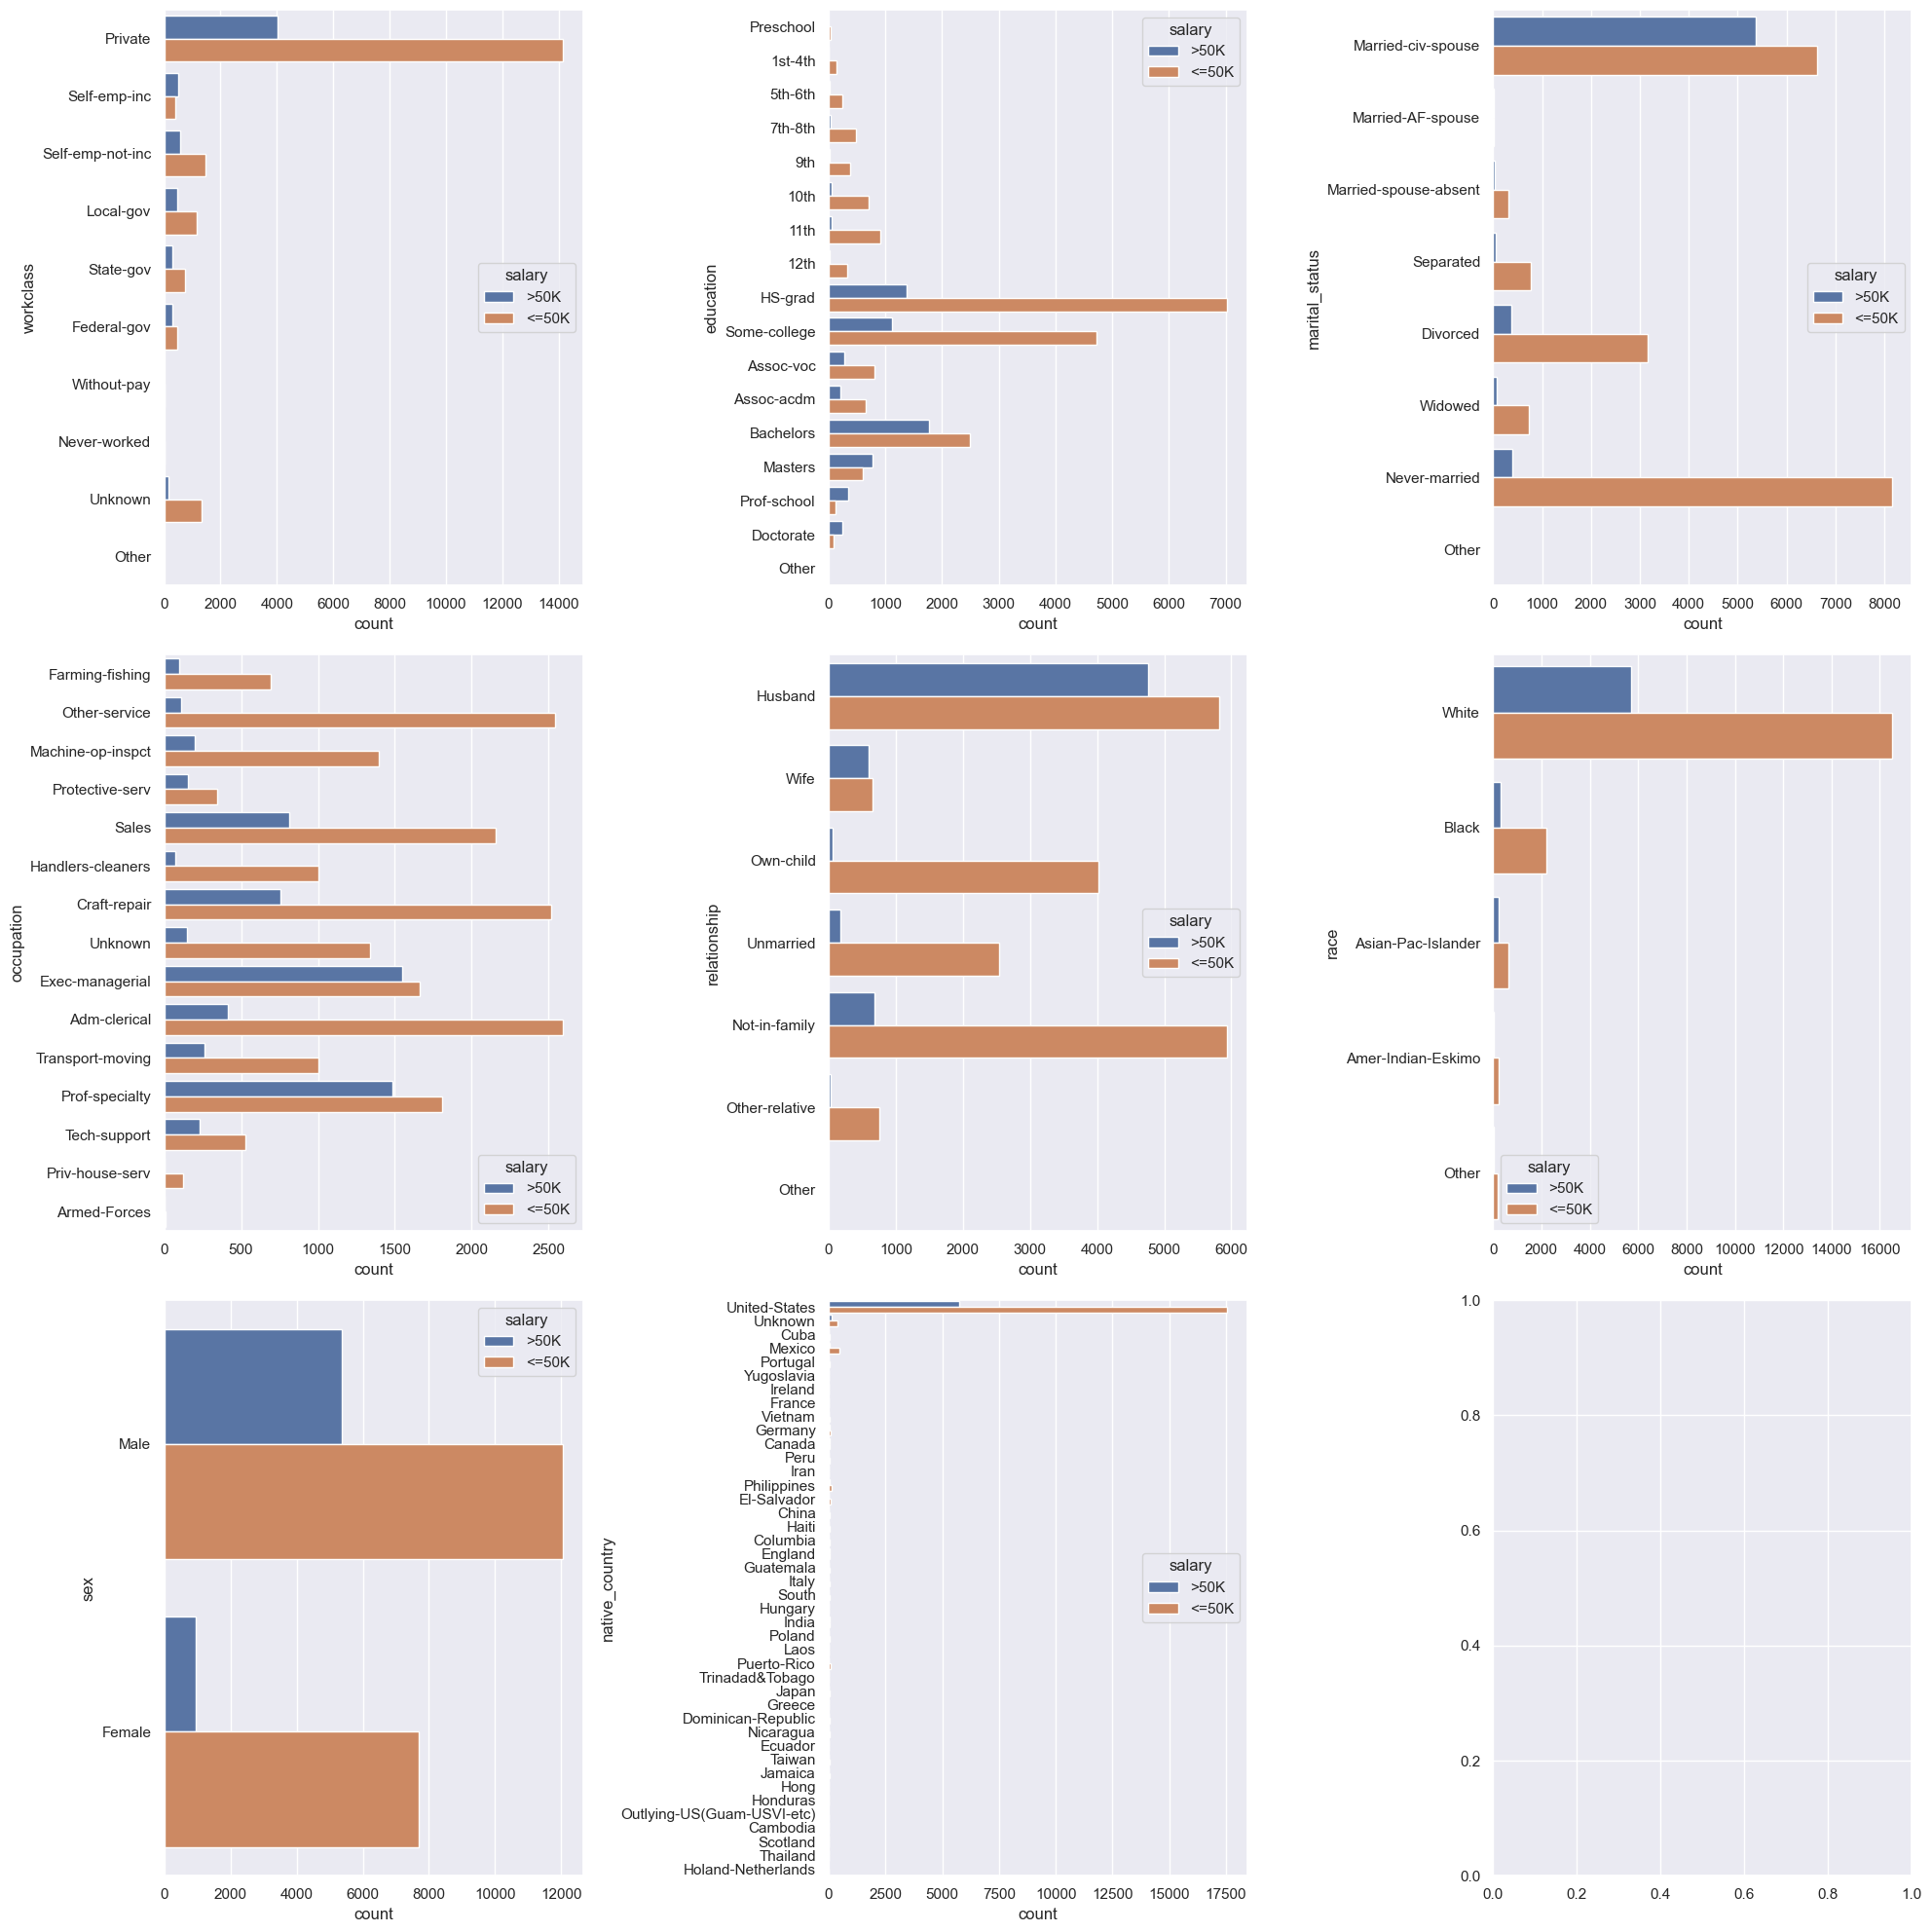

In [24]:
fig, axes = plt.subplots((len(cat_features) + 2) // 3, 3, figsize = (20, 20))

for i, cat_f in enumerate(cat_features):
    ix = i % 3
    iy = i // 3
    sns.countplot(
        data = df,
        y = cat_f,
        hue = target,
        ax = axes[iy, ix],
        order = cat_order[cat_f]
    )

plt.tight_layout()
plt.show()


#### Categorical variables - Plots with percentile filtration

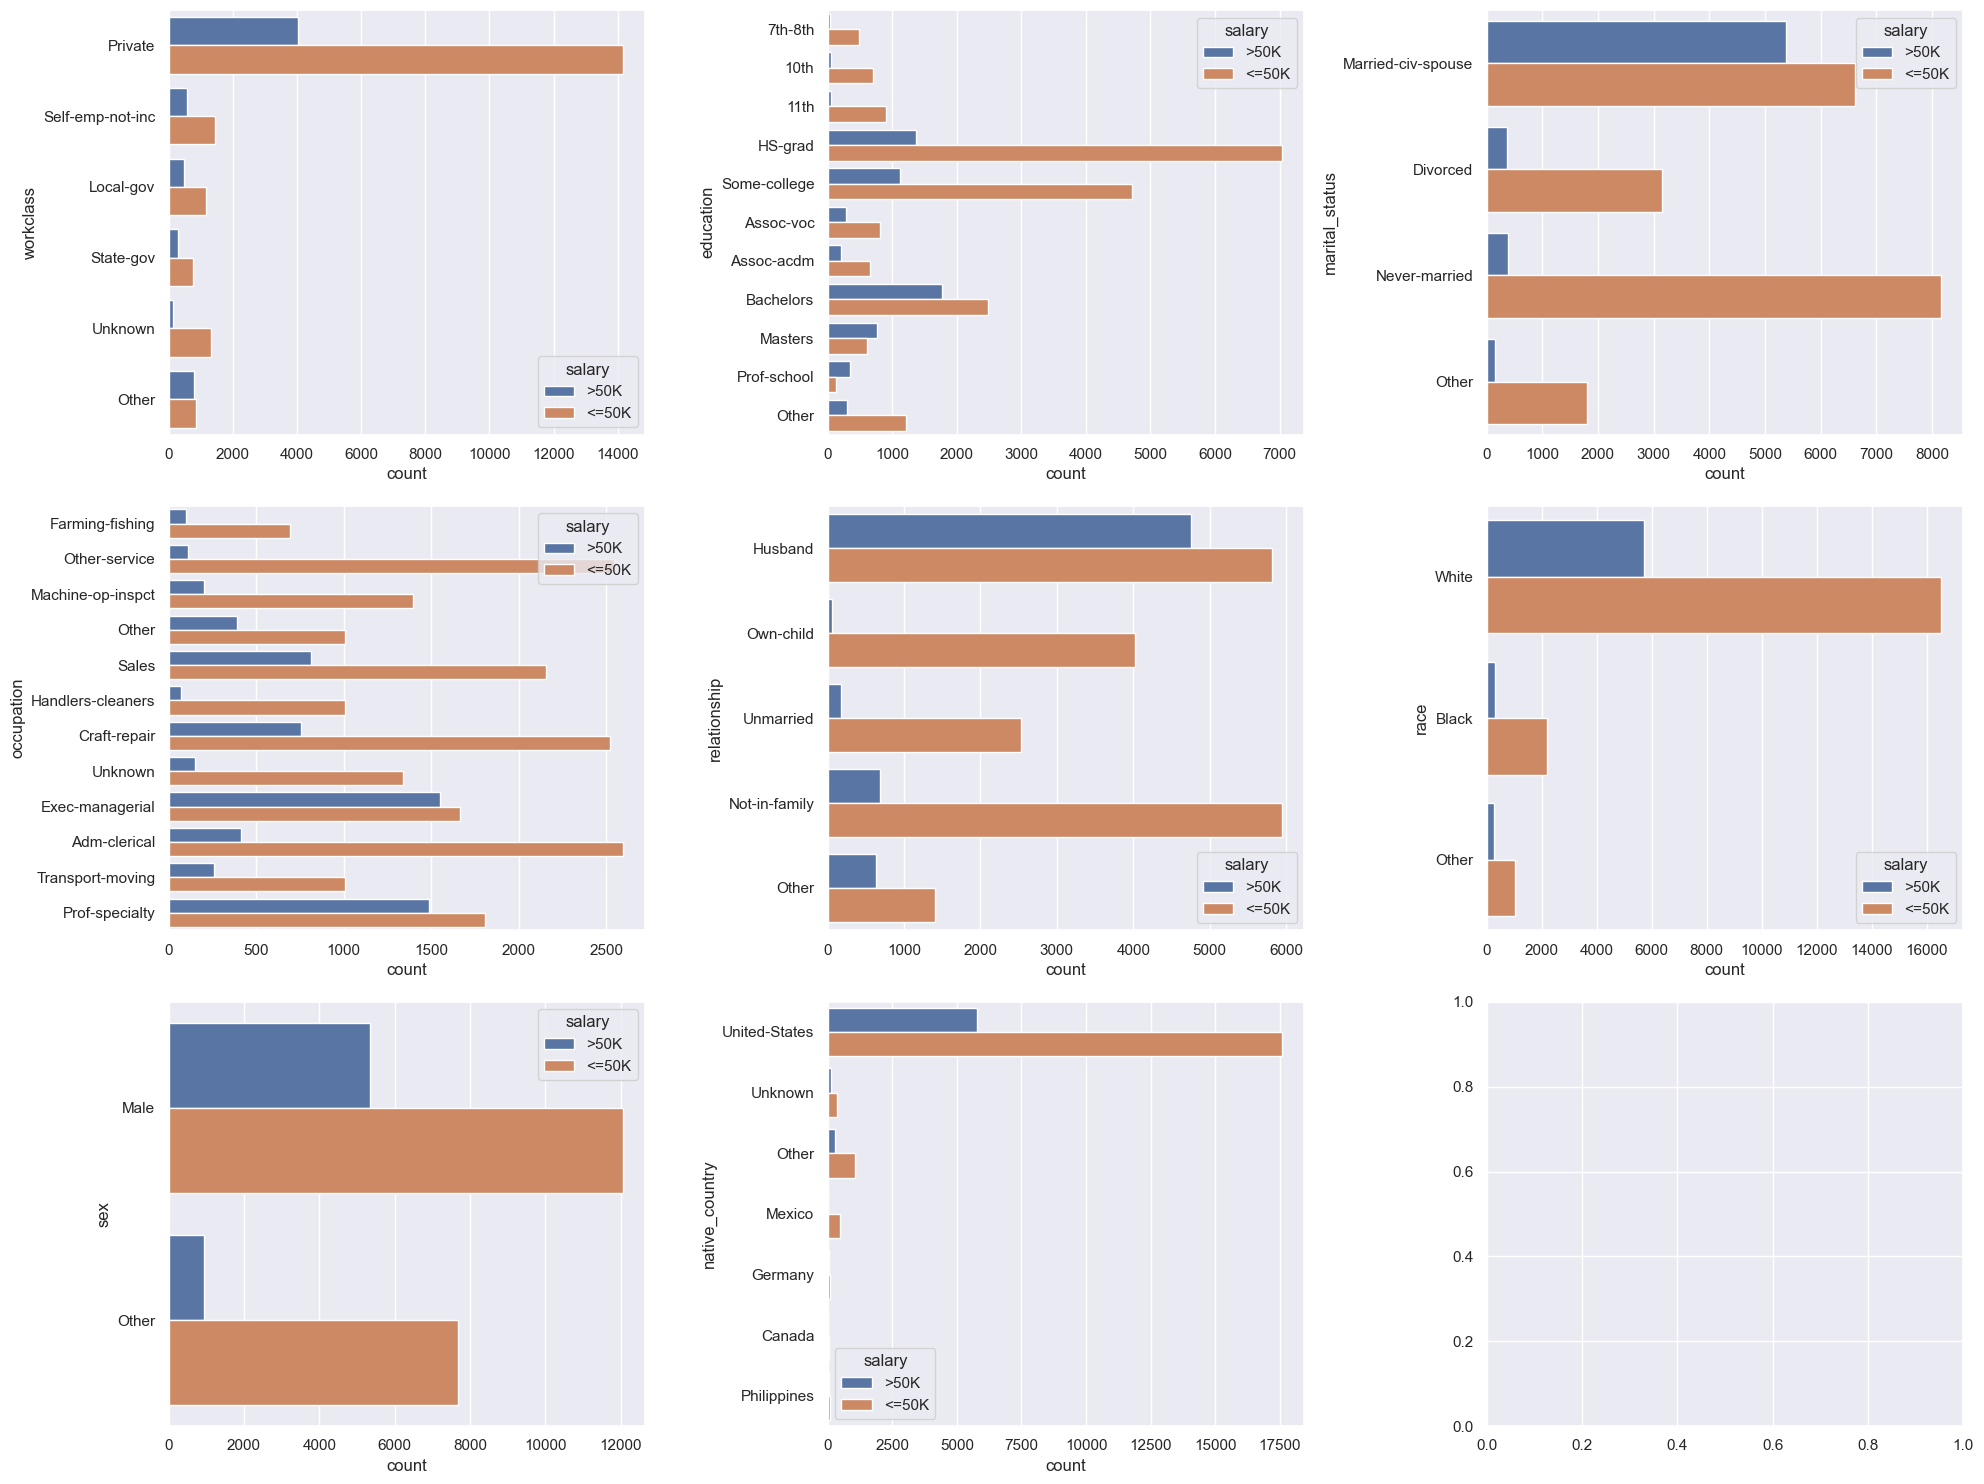

In [25]:
def _transform_get_percentile(df, cat_f, target, percentile = 0.95):
    
    tmp_df = df[[cat_f, target]].copy(deep = True)
    value_counts = tmp_df[cat_f].value_counts()
    within_percentile = value_counts[value_counts.cumsum() <= percentile * tmp_df.shape[0]].index.tolist()
    tmp_df[cat_f] = tmp_df[cat_f].map(lambda x: x if x in within_percentile else 'Other')

    return tmp_df


fig, axes = plt.subplots((len(cat_features) + 2) // 3, 3, figsize = (20, 15))

for i, cat_f in enumerate(cat_features):
    tmp_df = _transform_get_percentile(df, cat_f, target)
    ix = i % 3
    iy = i // 3
    tmp_order = [v for v in cat_order[cat_f] if v in tmp_df[cat_f].unique()] \
                if cat_order[cat_f] is not None else None
    sns.countplot(
        data = tmp_df,
        y = cat_f,
        hue = target,
        ax = axes[iy, ix],
        order = tmp_order
    )

plt.tight_layout()
plt.show()


#### Numeric variables

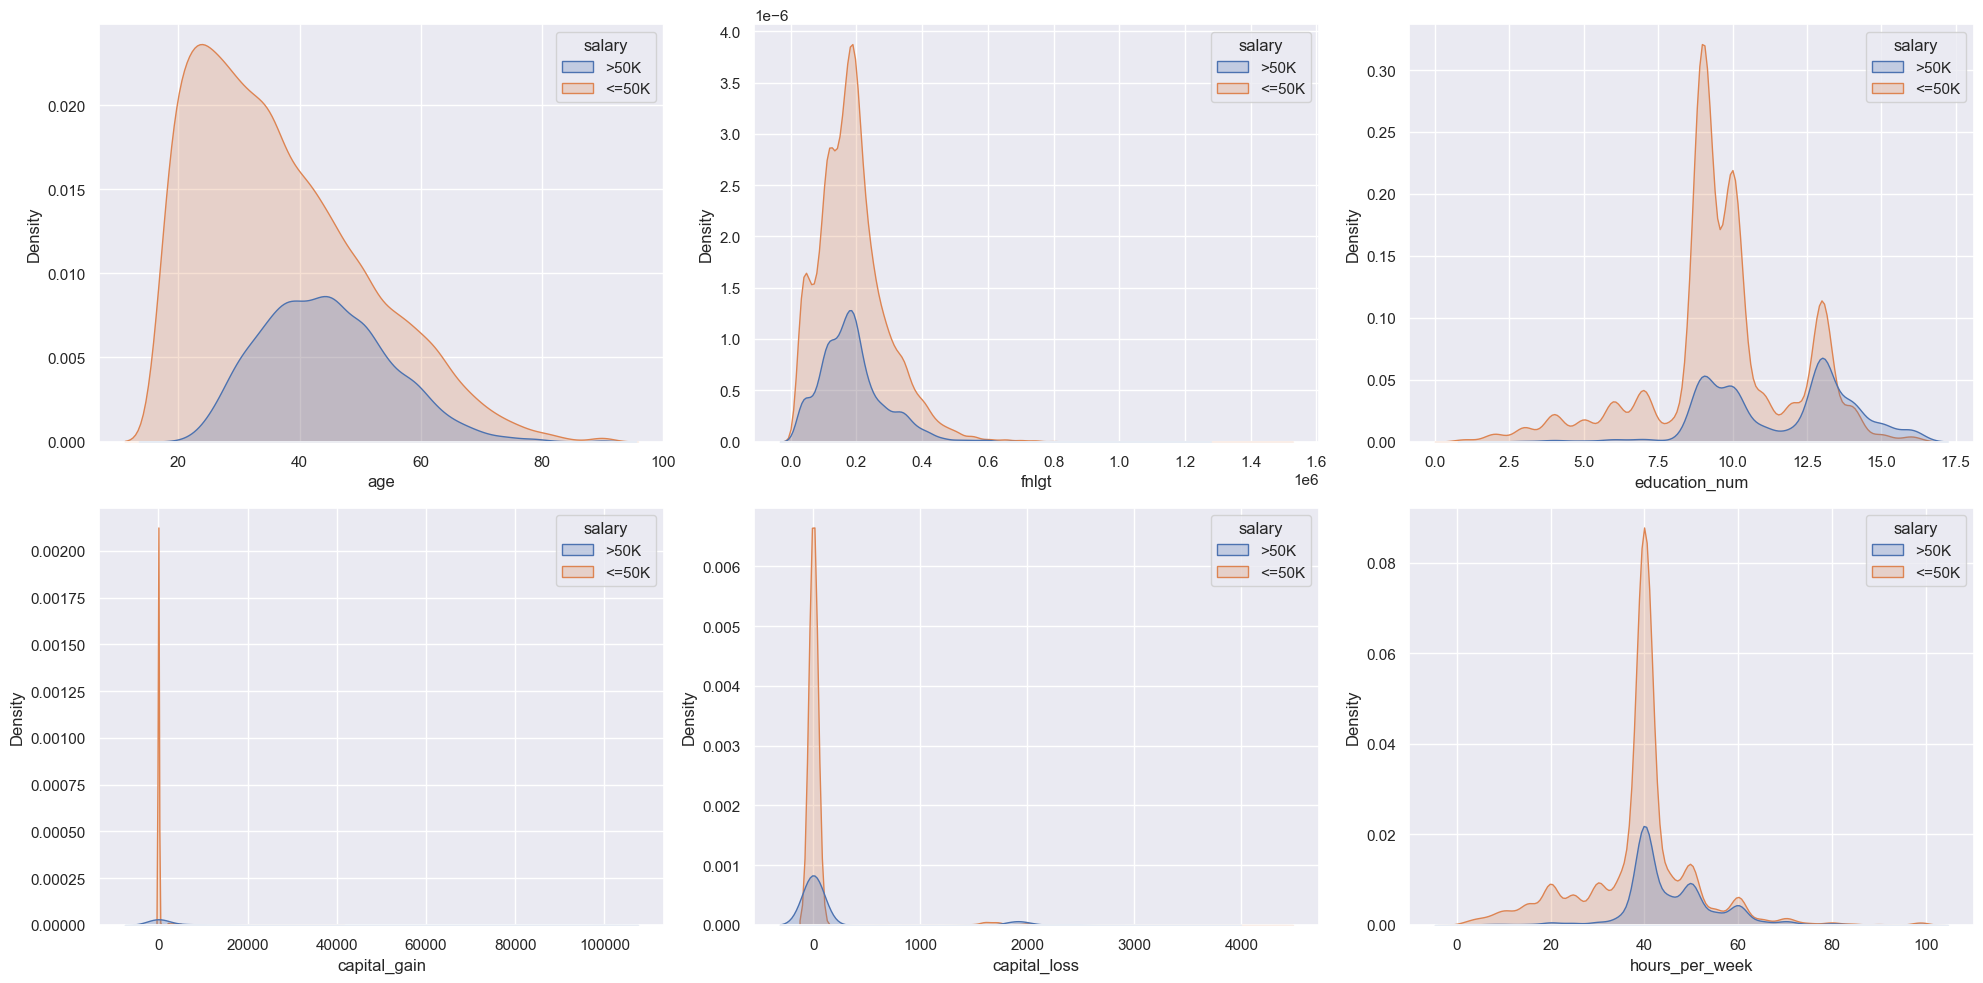

In [26]:
fig, axes = plt.subplots((len(num_features) + 2) // 3, 3, figsize = (20, 10))

for i, num_f in enumerate(num_features):
    ix = i % 3
    iy = i // 3
    sns.kdeplot(
        data = df, 
        x = num_f,
        hue = target,
        ax = axes[iy, ix],
        fill=True
    )


plt.tight_layout()
plt.show()


### Independent variables plots

#### `age`

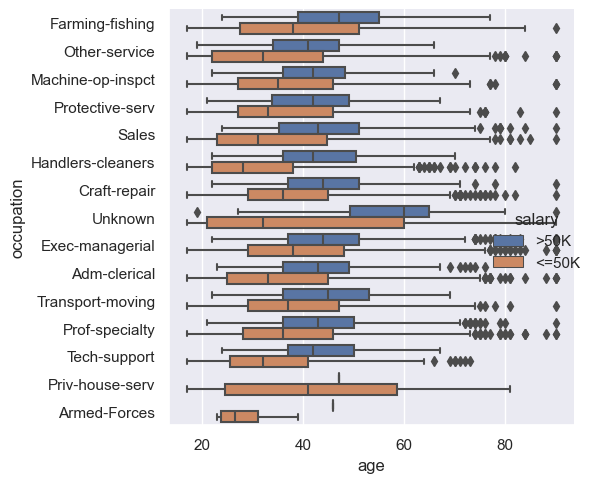

In [27]:
sns.catplot(
    x = 'age',
    y = 'occupation',
    hue = target,
    kind = 'box',
    data = df
)

plt.tight_layout()
plt.show()

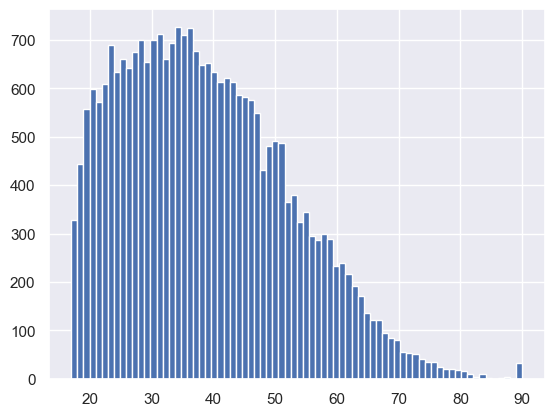

In [28]:
age = df['age']
assert age.between(17, 90).all()
age.hist(bins = 74)
plt.show()

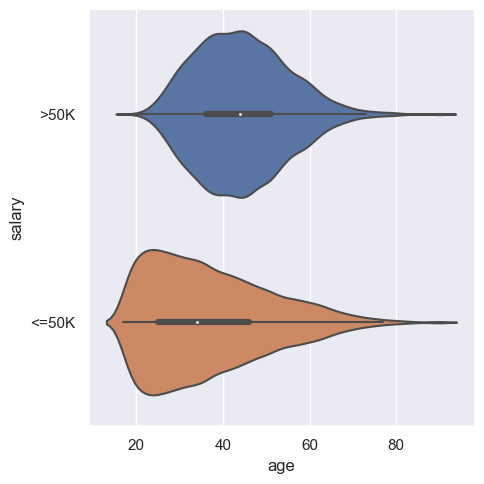

In [29]:
sns.catplot(
    x='age',
    y='salary',
    kind='violin',
    data=df
 )
plt.show()

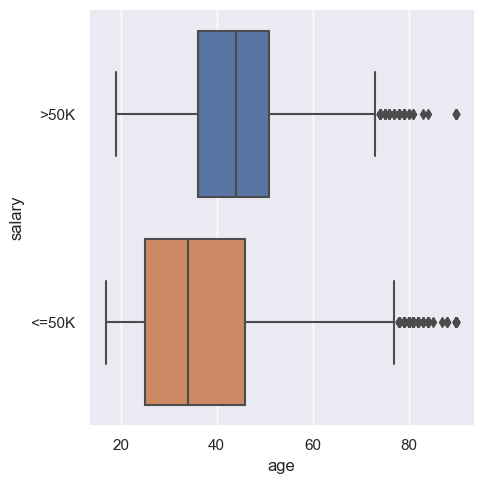

In [30]:
sns.catplot(
    x='age',
    y='salary',
    kind='box',
    data=df
 )
plt.show()

#### `workclass`

In [31]:
workclass = df['workclass']
workclass.value_counts()

Private             18175
Self-emp-not-inc     2040
Local-gov            1641
Unknown              1484
State-gov            1029
Self-emp-inc          879
Federal-gov           762
Without-pay            13
Never-worked            6
Name: workclass, dtype: int64

#### `fnlgt`

In [32]:
fnlgt = df['fnlgt']
pd.DataFrame(data = {'10 largest': fnlgt.nlargest(10).values, '10 smallest': fnlgt.nsmallest(10).values})

10 largest  10 smallest
0     1484705        12285
1     1455435        13769
2     1366120        18827
3     1268339        19214
4     1226583        19302
5     1184622        19302
6     1161363        19302
7     1097453        19302
8     1085515        19395
9     1038553        19395

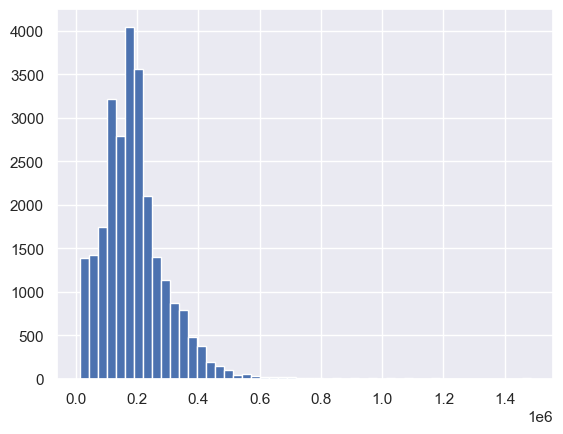

In [33]:
fnlgt.hist(bins = 50)
plt.show()

#### `education`

In [34]:
education = df['education']
education.value_counts()

HS-grad         8398
Some-college    5838
Bachelors       4264
Masters         1375
Assoc-voc       1090
11th             955
Assoc-acdm       865
10th             747
7th-8th          512
Prof-school      471
9th              397
12th             346
Doctorate        331
5th-6th          262
1st-4th          139
Preschool         39
Name: education, dtype: int64

#### `education_num`

In [35]:
education_num = df['education_num']
education_num.value_counts()

9     8398
10    5838
13    4264
14    1375
11    1090
7      955
12     865
6      747
4      512
15     471
5      397
8      346
16     331
3      262
2      139
1       39
Name: education_num, dtype: int64

#### `marital_status`

In [36]:
marital_status = df['marital_status']
marital_status.value_counts()

Married-civ-spouse       11998
Never-married             8549
Divorced                  3526
Separated                  813
Widowed                    789
Married-spouse-absent      334
Married-AF-spouse           20
Name: marital_status, dtype: int64

#### `occupation`

In [37]:
occupation = df['occupation']
occupation.value_counts()

Prof-specialty       3294
Craft-repair         3275
Exec-managerial      3214
Adm-clerical         3005
Sales                2968
Other-service        2655
Machine-op-inspct    1594
Unknown              1490
Transport-moving     1267
Handlers-cleaners    1076
Farming-fishing       794
Tech-support          761
Protective-serv       503
Priv-house-serv       124
Armed-Forces            9
Name: occupation, dtype: int64

#### `relationship`

In [38]:
relationship = df['relationship']
relationship.value_counts()

Husband           10575
Not-in-family      6629
Own-child          4076
Unmarried          2709
Wife               1249
Other-relative      791
Name: relationship, dtype: int64

#### `race`

In [39]:
race = df['race']
race.value_counts()

White                 22218
Black                  2492
Asian-Pac-Islander      846
Amer-Indian-Eskimo      262
Other                   211
Name: race, dtype: int64

#### `sex`

In [40]:
sex = df['sex']
sex.value_counts()

Male      17407
Female     8622
Name: sex, dtype: int64

#### `capital_gain`

In [41]:
capital_gain = df['capital_gain']
pd.DataFrame(data = {'10 largest': capital_gain.nlargest(10).values, '10 smallest': capital_gain.nsmallest(10).values})

10 largest  10 smallest
0       99999            0
1       99999            0
2       99999            0
3       99999            0
4       99999            0
5       99999            0
6       99999            0
7       99999            0
8       99999            0
9       99999            0

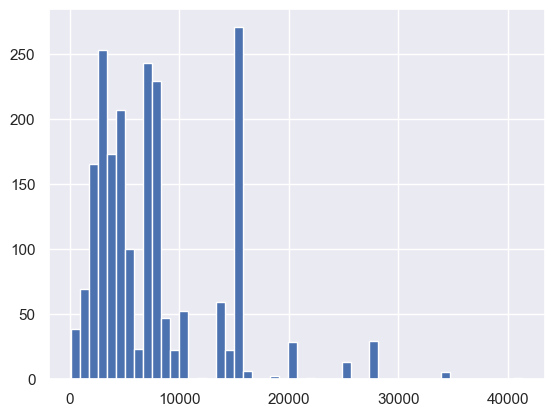

In [42]:
capital_gain[(capital_gain != 0) & (capital_gain != 99999)].hist(bins = 50)
plt.show()

#### `capital_loss`

In [43]:
capital_loss = df['capital_loss']
pd.DataFrame(data = {'10 largest': capital_loss.nlargest(10).values, '10 smallest': capital_loss.nsmallest(10).values})

10 largest  10 smallest
0        4356            0
1        4356            0
2        3900            0
3        3770            0
4        3770            0
5        3683            0
6        3004            0
7        3004            0
8        2824            0
9        2824            0

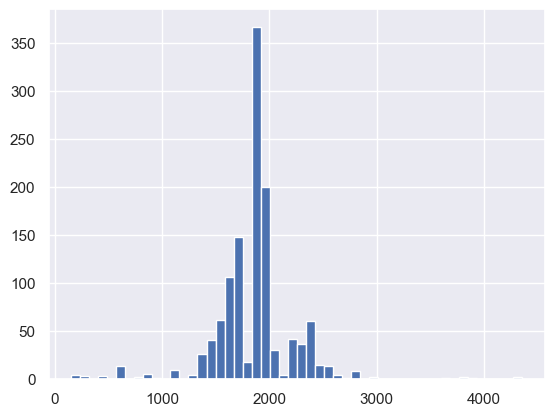

In [44]:
capital_loss[capital_loss != 0].hist(bins = 50)
plt.show()

#### `hours_per_week`

In [45]:
hours_per_week = df['hours_per_week']
pd.DataFrame(data = {'10 largest': hours_per_week.nlargest(10).values, '10 smallest': hours_per_week.nsmallest(10).values})

10 largest  10 smallest
0          99            1
1          99            1
2          99            1
3          99            1
4          99            1
5          99            1
6          99            1
7          99            1
8          99            1
9          99            1

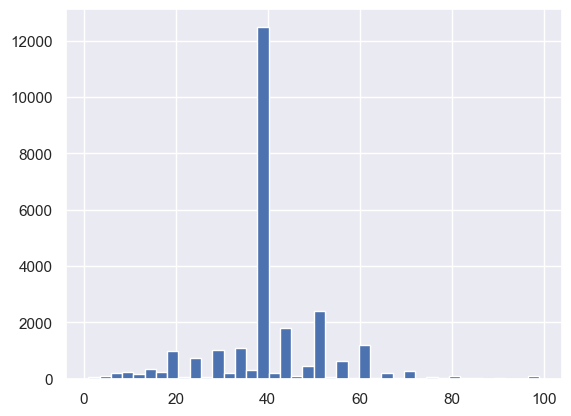

In [46]:
hours_per_week.hist(bins = 40)
plt.show()

#### `native_country`

In [47]:
native_country = df['native_country']
native_country.value_counts()

United-States                 23331
Mexico                          492
Unknown                         486
Philippines                     156
Germany                         117
Canada                           96
El-Salvador                      92
Puerto-Rico                      86
England                          74
India                            73
Cuba                             69
South                            64
China                            62
Jamaica                          62
Vietnam                          58
Italy                            55
Dominican-Republic               54
Japan                            50
Columbia                         45
Poland                           45
Guatemala                        43
Taiwan                           39
Haiti                            38
Iran                             34
Portugal                         29
Nicaragua                        29
Peru                             25
Greece                      

## Model bias

### Preprocessing

In [48]:
y = df[target]
X = df.loc[:, df.columns != target]

y = target_encoder.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, stratify = y, random_state = RANDOM_STATE)

df_aq = X_test.copy(deep = True)

In [49]:
df_aq['label_value'] = y_test
df_aq['score'] = y_pred
df_aq.head()

workclass  education      marital_status         occupation  \
24745  Local-gov    HS-grad  Married-civ-spouse    Protective-serv   
12913    Private  Assoc-voc            Divorced              Sales   
5810     Private    HS-grad  Married-civ-spouse  Machine-op-inspct   
13462    Private    HS-grad       Never-married    Exec-managerial   
23717    Unknown    HS-grad  Married-civ-spouse            Unknown   

        relationship   race   sex native_country  age   fnlgt  education_num  \
24745        Husband  White  Male  United-States   31  206609              9   
12913  Not-in-family  White  Male  United-States   44  403782             11   
5810         Husband  White  Male  United-States   32  262153              9   
13462      Own-child  White  Male  United-States   27  168138              9   
23717        Husband  White  Male  United-States   63   29859              9   

       capital_gain  capital_loss  hours_per_week  label_value  score  
24745             0             0              40            1      0  
12913             0             0              45            0      0  
5810              0             0              40            0      0  
13462             0             0              40            0      0  
23717             0          1485              40            1      0

In [50]:
qcut_cols = [n for n in num_features if n not in ['fnlgt', 'education_num', 'capital_gain', 'capital_loss']]
for num_f in qcut_cols:
    df_aq[num_f + '_qcut'] = pd.qcut(df_aq[num_f], 10, duplicates = 'drop').astype(str)
aq_cols = cat_features + [n + '_qcut' for n in qcut_cols] + ['label_value', 'score']
df_aq = df_aq.loc[:, aq_cols]
df_aq.head()

workclass  education      marital_status         occupation  \
24745  Local-gov    HS-grad  Married-civ-spouse    Protective-serv   
12913    Private  Assoc-voc            Divorced              Sales   
5810     Private    HS-grad  Married-civ-spouse  Machine-op-inspct   
13462    Private    HS-grad       Never-married    Exec-managerial   
23717    Unknown    HS-grad  Married-civ-spouse            Unknown   

        relationship   race   sex native_country      age_qcut  \
24745        Husband  White  Male  United-States  (30.0, 34.0]   
12913  Not-in-family  White  Male  United-States  (41.0, 45.0]   
5810         Husband  White  Male  United-States  (30.0, 34.0]   
13462      Own-child  White  Male  United-States  (26.0, 30.0]   
23717        Husband  White  Male  United-States  (58.0, 90.0]   

      hours_per_week_qcut  label_value  score  
24745        (35.0, 40.0]            1      0  
12913        (42.0, 50.0]            0      0  
5810         (35.0, 40.0]            0      0  
13462        (35.0, 40.0]            0      0  
23717        (35.0, 40.0]            1      0

In [51]:
# merge small group frequencies
def _transform_get_percentile(df, cat_f, target, percentile = 0.95):
    
    tmp_df = df[[cat_f, target]].copy(deep = True)
    value_counts = tmp_df[cat_f].value_counts()
    within_percentile = value_counts[value_counts.cumsum() <= percentile * tmp_df.shape[0]].index.tolist()
    tmp_df[cat_f] = tmp_df[cat_f].map(lambda x: x if x in within_percentile else 'Other')

    return tmp_df

for cat_f in cat_features:
    df_aq[cat_f] = _transform_get_percentile(df, cat_f, target)[cat_f]

### Biases across subgroups

In [52]:
from aequitas.group import Group
from aequitas.bias import Bias 
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

aqp = Plot()

In [53]:
group = Group()
xtab, idxs = group.get_crosstabs(df_aq)
absolute_metrics = group.list_absolute_metrics(xtab)

# xtab[[col for col in xtab.columns if col not in absolute_metrics + ['model_id', 'score_threshold', 'k', 'pp', 'pn', 'group_label_pos', 'group_label_neg']]]
group_size_fr = xtab['group_size'] / xtab['total_entities']
xtab.loc[group_size_fr >= 0.05, ['attribute_name', 'attribute_value', 'tp', 'fp', 'tn', 'fn', 'tpr', 'tnr', 'precision', 'npv', 'group_size', 'total_entities']].round(2)

attribute_name     attribute_value   tp   fp    tn   fn   tpr   tnr  \
0             workclass           Local-gov   78   22   197   31  0.72  0.90   
1             workclass               Other  139   47   122   30  0.82  0.72   
2             workclass             Private  511  142  2721  262  0.66  0.95   
3             workclass    Self-emp-not-inc   58   16   274   58  0.50  0.94   
5             workclass             Unknown   12    1   256   22  0.35  1.00   
11            education           Bachelors  295   82   425   71  0.81  0.84   
12            education             HS-grad   98   44  1407  157  0.38  0.97   
14            education               Other   60    9   213    7  0.90  0.96   
16            education        Some-college  135   47   872   98  0.58  0.95   
17       marital_status            Divorced   38    4   624   44  0.46  0.99   
18       marital_status  Married-civ-spouse  757  233  1059  300  0.72  0.82   
19       marital_status       Never-married   36    6  1639   51  0.41  1.00   
20       marital_status               Other   14    0   381   20  0.41  1.00   
21           occupation        Adm-clerical   48   15   500   33  0.59  0.97   
22           occupation        Craft-repair   63   12   486  100  0.39  0.98   
23           occupation     Exec-managerial  235   73   277   52  0.82  0.79   
26           occupation   Machine-op-inspct    9    2   291   29  0.24  0.99   
27           occupation               Other   54   14   177   28  0.66  0.93   
28           occupation       Other-service    1    1   512   17  0.06  1.00   
29           occupation      Prof-specialty  270   63   271   54  0.83  0.81   
30           occupation               Sales  118   47   396   34  0.78  0.89   
32           occupation             Unknown   12    1   257   22  0.35  1.00   
33         relationship             Husband  674  204   925  274  0.71  0.82   
34         relationship       Not-in-family   69   11  1231   74  0.48  0.99   
35         relationship               Other   84   27   255   29  0.74  0.90   
36         relationship           Own-child    3    1   788   16  0.16  1.00   
37         relationship           Unmarried   15    0   504   22  0.41  1.00   
38                 race               Black   44    7   416   21  0.68  0.98   
39                 race               Other   35   18   201   15  0.70  0.92   
40                 race               White  766  218  3086  379  0.67  0.93   
41                  sex                Male  732  214  2198  346  0.68  0.91   
42                  sex               Other  113   29  1505   69  0.62  0.98   
48       native_country       United-States  781  219  3323  385  0.67  0.94   
50             age_qcut      (16.999, 22.0]    0    1   627    2  0.00  1.00   
51             age_qcut        (22.0, 26.0]    5    3   487   17  0.23  0.99   
52             age_qcut        (26.0, 30.0]   36    5   446   39  0.48  0.99   
53             age_qcut        (30.0, 34.0]   73   33   384   53  0.58  0.92   
54             age_qcut        (34.0, 37.0]   79   26   276   37  0.68  0.91   
55             age_qcut        (37.0, 41.0]  141   36   301   48  0.75  0.89   
56             age_qcut        (41.0, 45.0]  126   31   281   58  0.68  0.90   
57             age_qcut        (45.0, 51.0]  187   48   312   62  0.75  0.87   
58             age_qcut        (51.0, 58.0]  118   37   242   44  0.73  0.87   
59             age_qcut        (58.0, 90.0]   80   23   347   55  0.59  0.94   
60  hours_per_week_qcut       (0.999, 25.0]   23    3   579   20  0.53  0.99   
61  hours_per_week_qcut        (25.0, 35.0]   29    7   408   24  0.55  0.98   
62  hours_per_week_qcut        (35.0, 40.0]  331  105  1903  190  0.64  0.95   
64  hours_per_week_qcut        (42.0, 50.0]  293   68   522  103  0.74  0.88   
66  hours_per_week_qcut        (55.0, 99.0]  110   41   208   48  0.70  0.84   

    precision   npv  group_size  total_entities  
0        0.78  0.86         328       

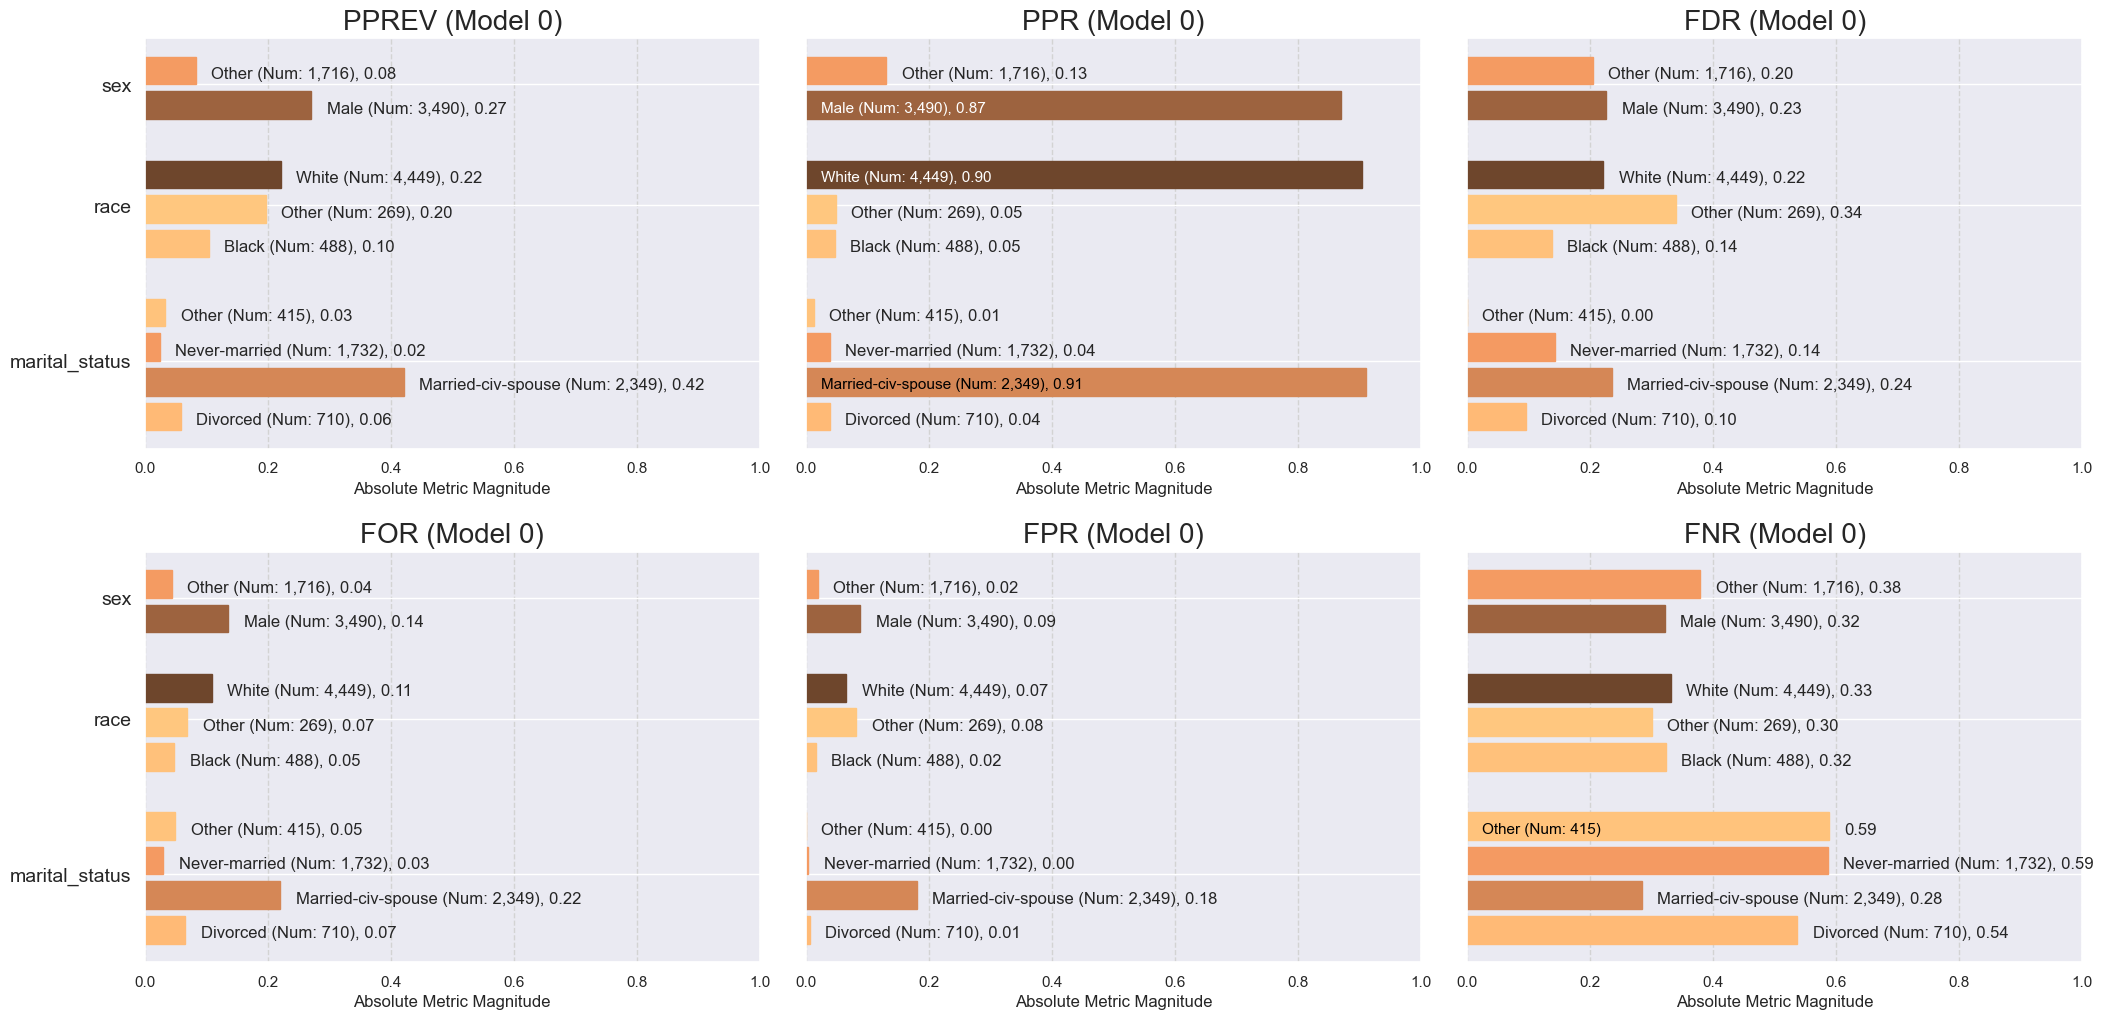

<Figure size 640x480 with 0 Axes>

In [54]:
fnr = aqp.plot_group_metric_all(xtab[(group_size_fr >= 0.01) & xtab['attribute_name'].isin(['marital_status', 'race', 'sex'])], ncols = 3)

### Disparsity levels across groups w.r.t. majority group

In [55]:
# define major groups
ref_group = {}
for c in cat_features + [n + '_qcut' for n in qcut_cols]:
    ref_group[c] = df_aq[c].value_counts().index[0]

bias = Bias()
bias_df = bias.get_disparity_predefined_groups(
    xtab, original_df = df_aq,
    ref_groups_dict = ref_group,
    alpha = 0.05, check_significance = True, mask_significance=True)

get_disparity_predefined_group()


/home/biddy/miniconda3/envs/udacity-mldevops-3rd-project/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/biddy/miniconda3/envs/udacity-mldevops-3rd-project/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/biddy/miniconda3/envs/udacity-mldevops-3rd-project/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/biddy/miniconda3/envs/udacity-mldevops-3rd-project/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/biddy/miniconda3/envs/udacity-ml

In [56]:
metric = 'npv'
bias_df.loc[
    (bias_df[metric + '_significance'] == True) & bias_df['attribute_name'].isin(['marital_status', 'race', 'sex', 'native_country']), 
    ['attribute_name', 'attribute_value', 'group_size', 'label_value_significance', 'score_significance', metric + '_disparity', metric + '_significance', metric + '_ref_group_value']
]

attribute_name attribute_value  group_size  label_value_significance  \
17  marital_status        Divorced         710                      True   
19  marital_status   Never-married        1732                      True   
20  marital_status           Other         415                      True   
38            race           Black         488                      True   
39            race           Other         269                      True   
42             sex           Other        1716                      True   
46  native_country           Other         255                      True   

    score_significance  npv_disparity  npv_significance npv_ref_group_value  
17                True       1.198758              True  Married-civ-spouse  
19                True       1.244560              True  Married-civ-spouse  
20               False       1.219282              True  Married-civ-spouse  
38                True       1.068856              True               White  
39               False       1.044840              True               White  
42               False       1.106678              True                Male  
46               False       1.051483              True       United-States

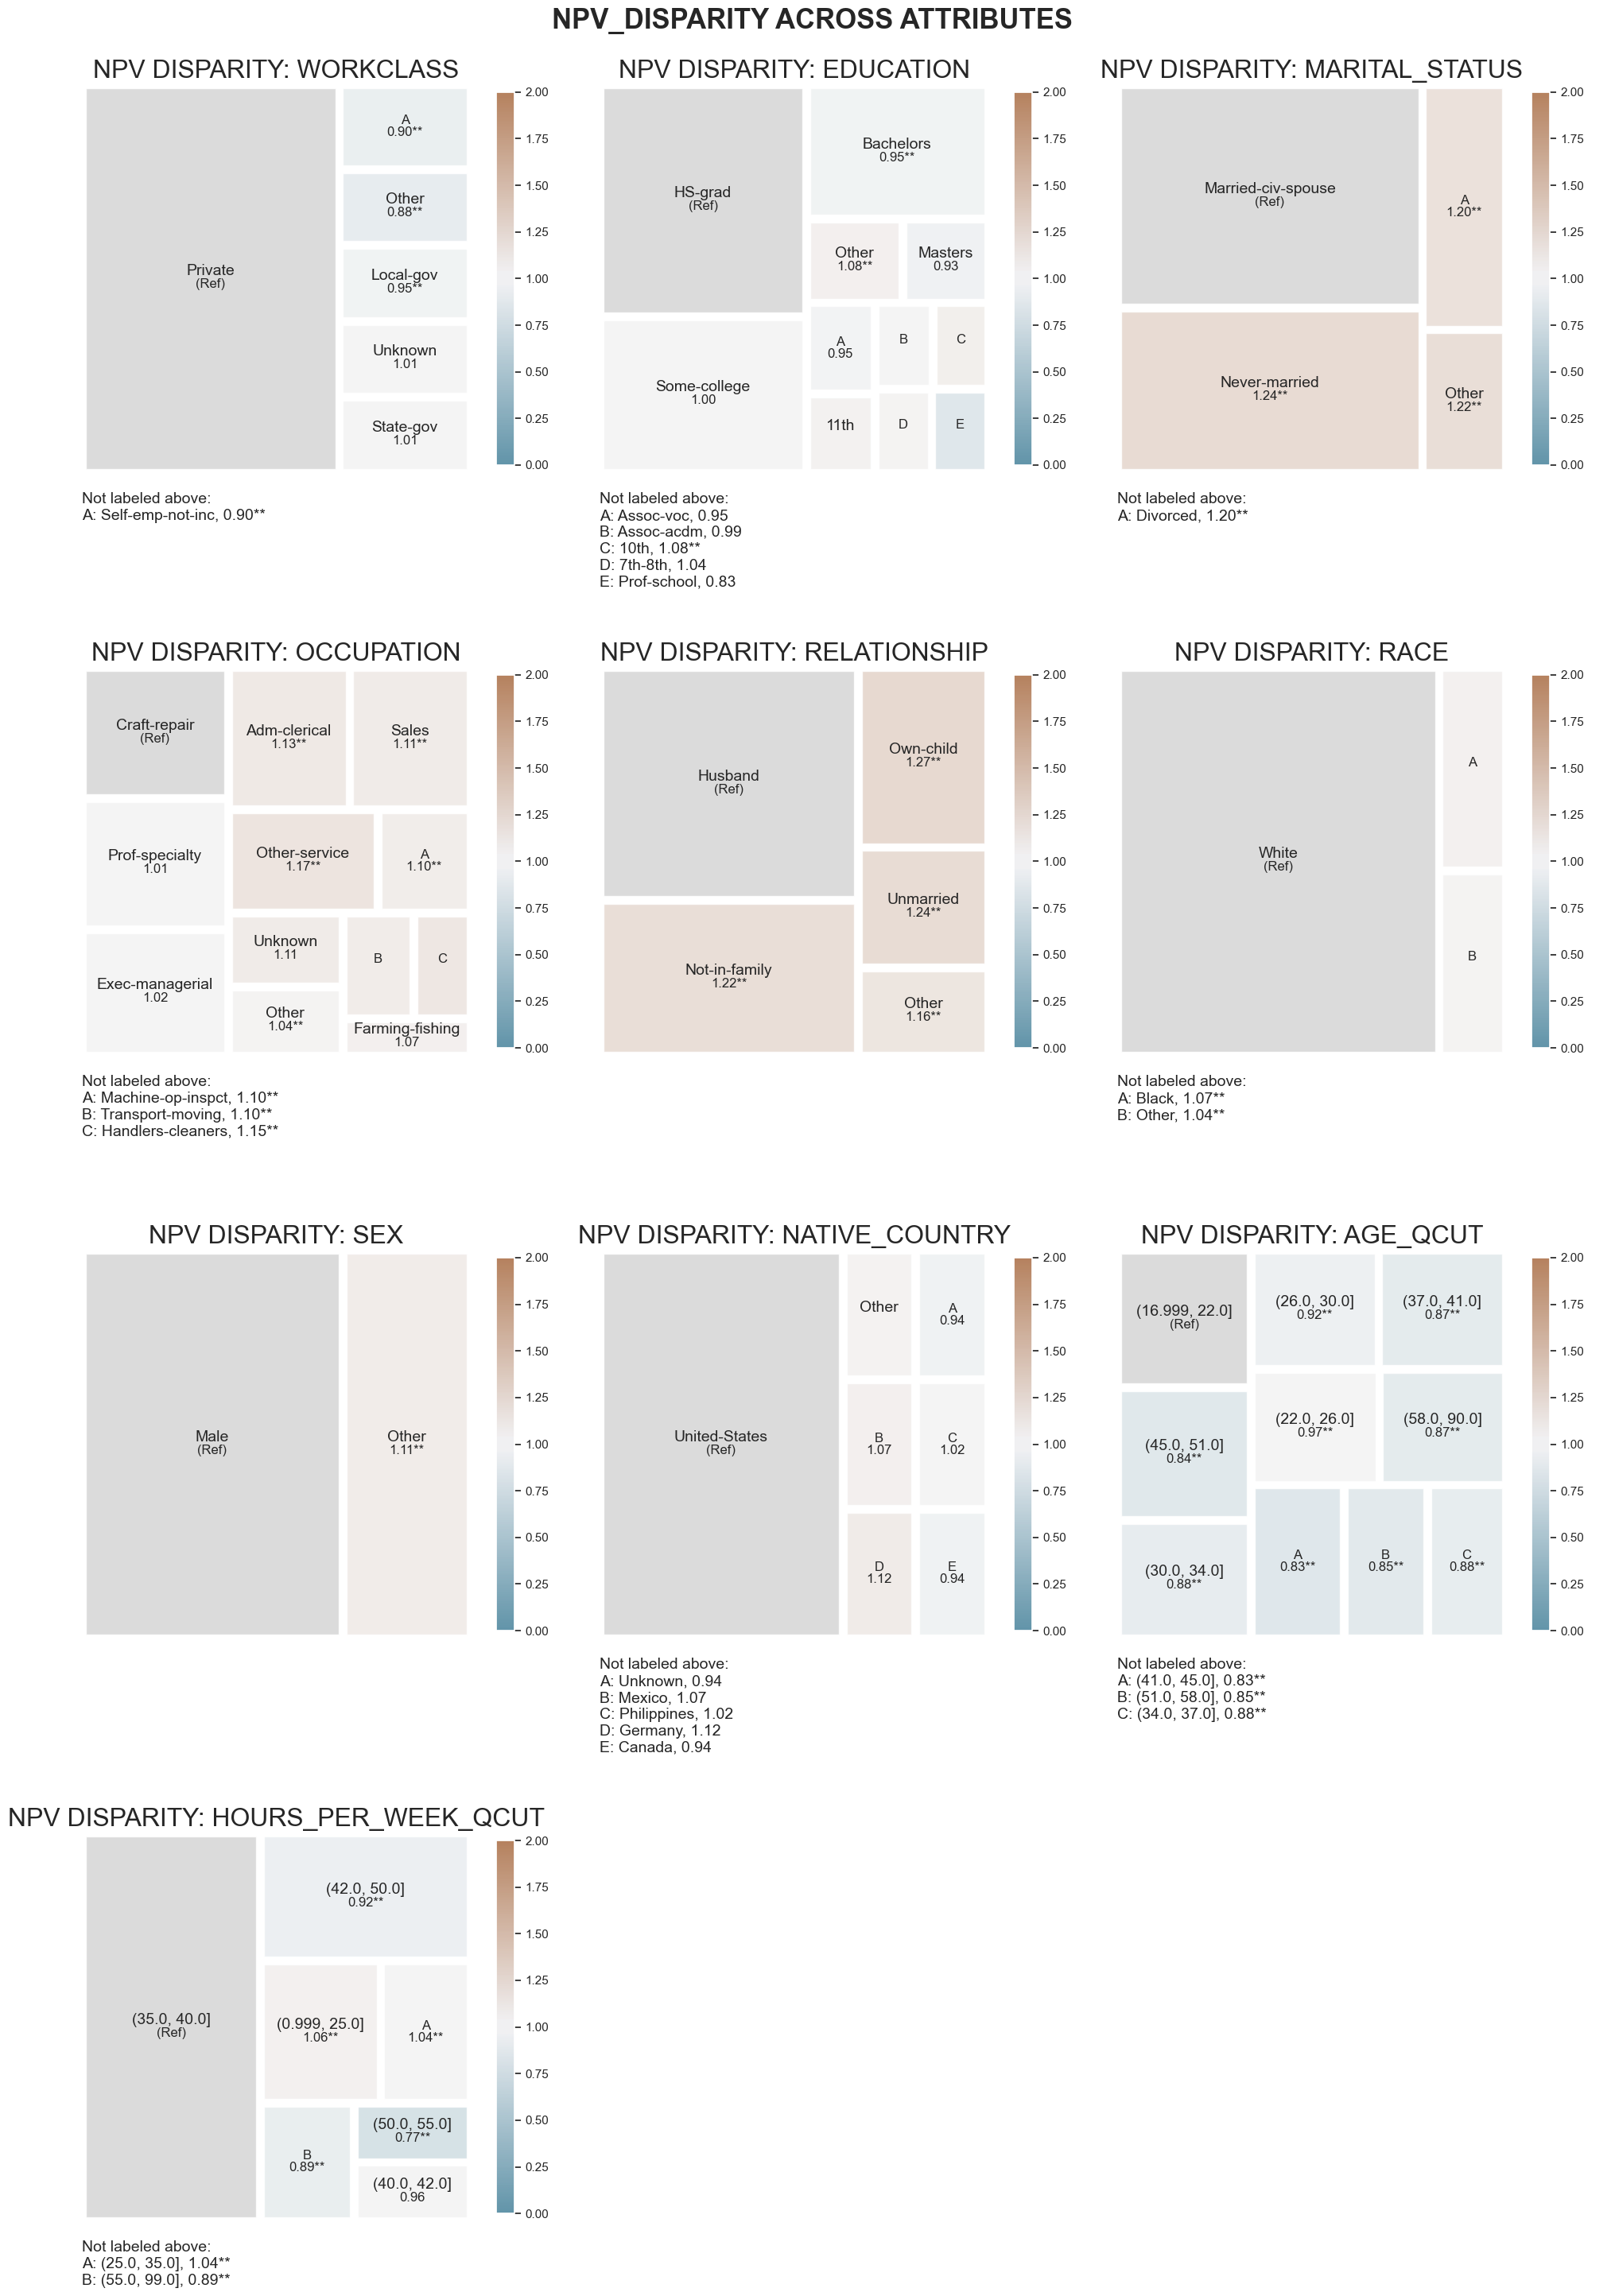

In [57]:
_ = aqp.plot_disparity_all(bias_df, metrics = [metric + '_disparity'], significance_alpha=0.05)

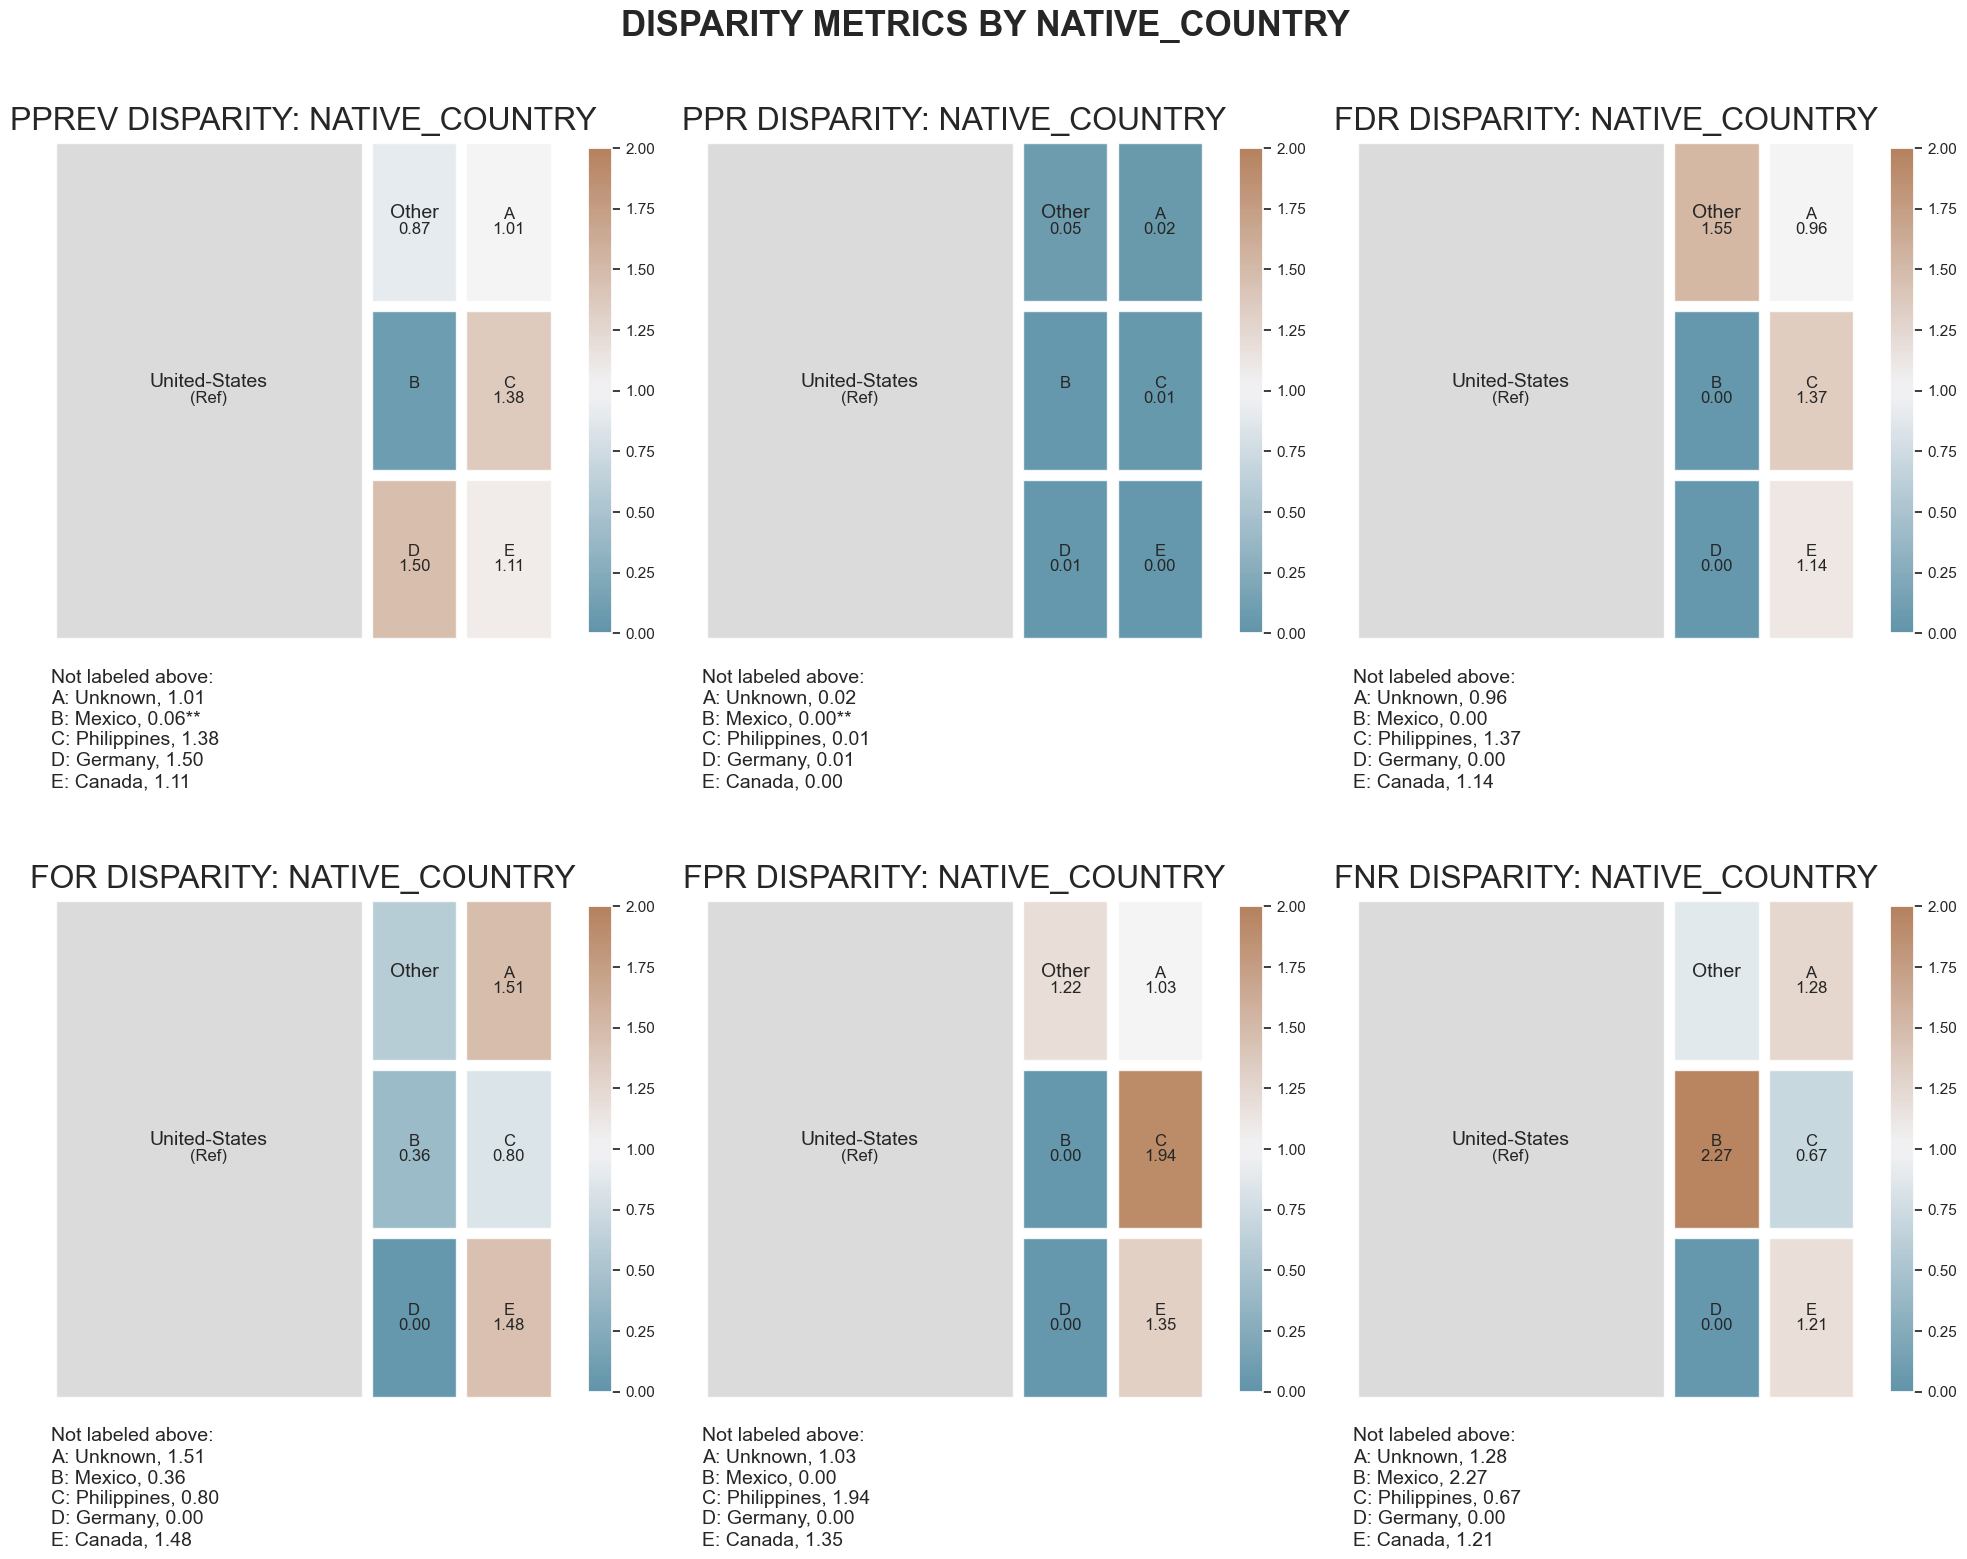

In [58]:
_ = aqp.plot_disparity_all(bias_df, attributes = ['native_country'], significance_alpha=0.05)

### Model and group level fairness

In [59]:
fairness = Fairness()
fairness_df = fairness.get_group_value_fairness(bias_df)

gof = fairness.get_overall_fairness(fairness_df)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

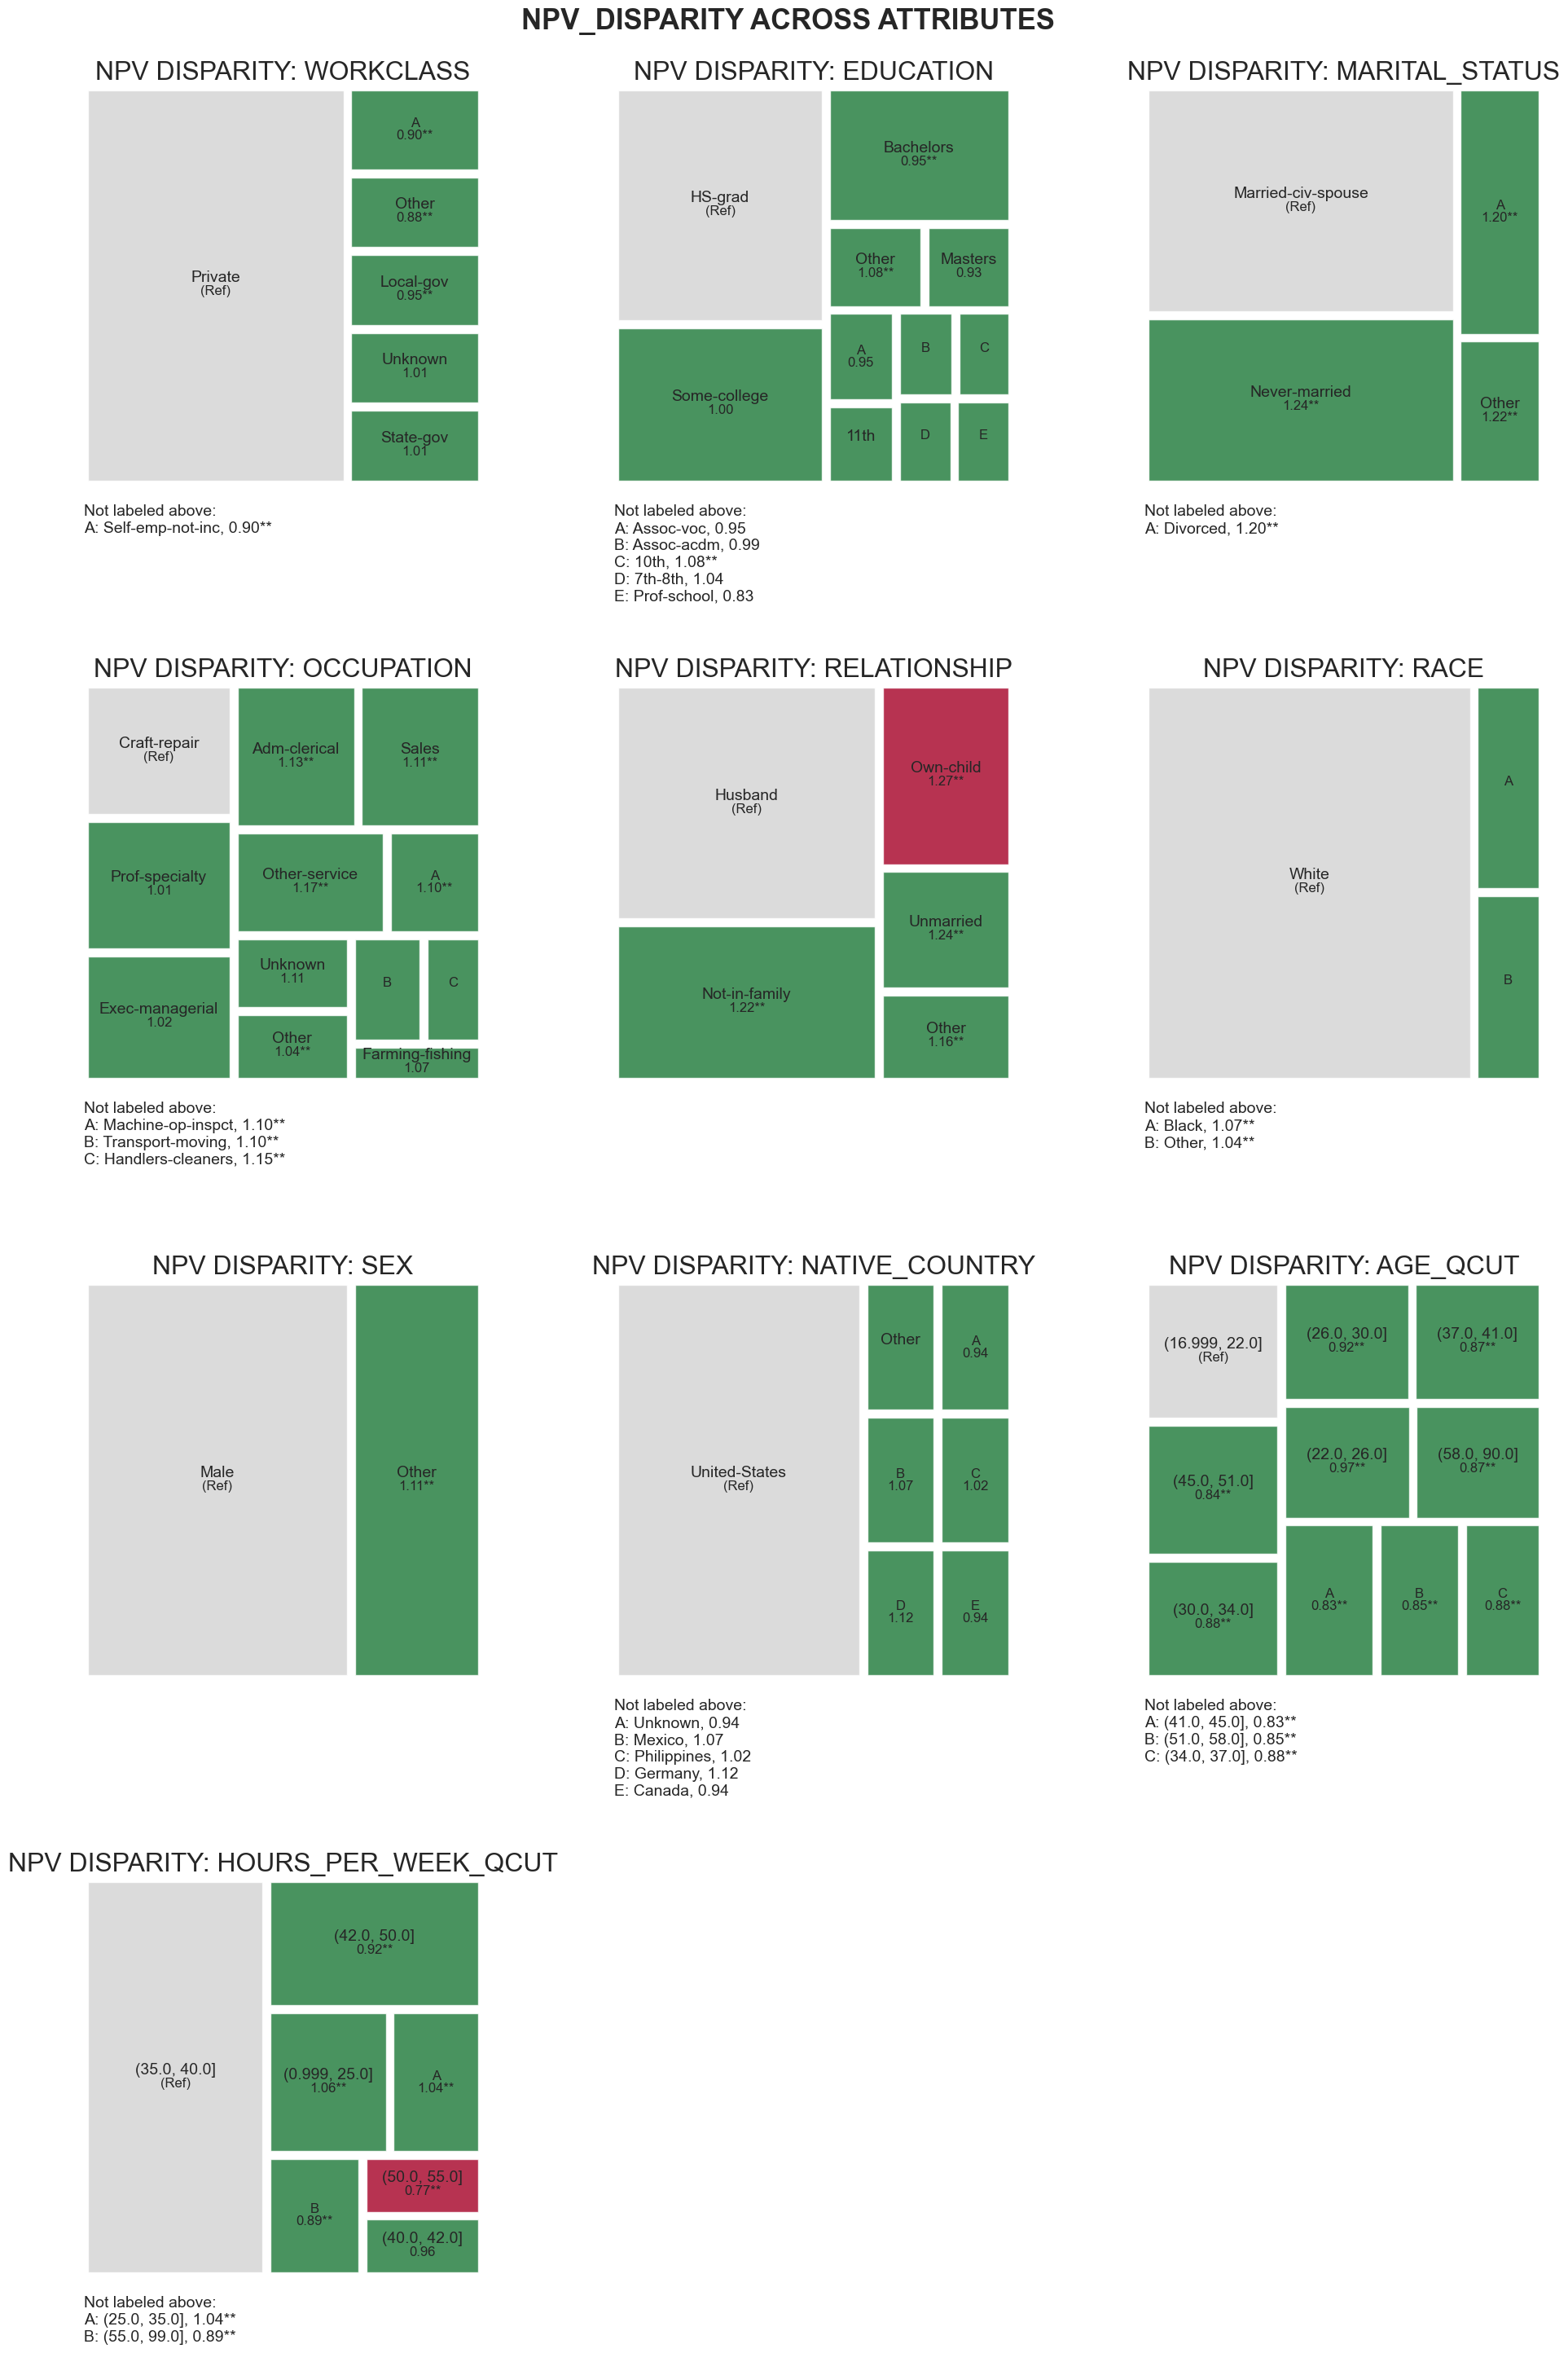

In [60]:
_ = aqp.plot_fairness_disparity_all(bias_df, metrics=[metric + '_disparity'], significance_alpha=0.05)